In [37]:
import os, sys
import pandas as pd
import pickle
from os.path import dirname, abspath
d = os.path.abspath(os.path.join('..'))
sys.path.append(d)
from model_trial import Experiment
from util.file_processor import FileProcessor
from sklearn.metrics import mean_absolute_error
from sklearn import tree
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({'font.size': 8, 'figure.figsize' : [1.0*3.125, 1.5*0.8],
                           'legend.fontsize': 10, 'legend.fancybox': True,
                           'font.family': 'serif', 'font.sans-serif': 'Times',
                            'xtick.major.width': 0.2, 'xtick.minor.width': 2*0.2,
                            'ytick.major.width': 0.2, 'ytick.minor.width': 2*0.2,
                            'text.usetex': False, 'axes.labelsize': 7*2,
                            'axes.spines.right': False, 'axes.spines.top': False
                           })
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import numpy as np
import re
import graphviz
import pathlib
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Process Model Intermediates

In [38]:
%run '../util/webrtc_reader.py'
%run '../util/helper_functions.py'

In [10]:
dataset = 'IMC_Lab_data'
data_dir = '/home/taveesh/Documents/Projects/vca-qoe-inference/data'
cross_validations = 5
tested_vcas = ['meet', 'teams', 'webex']
traces_available = False
timestamps_available = False
metrics = ['framesReceivedPerSecond', 'bitrate', 'frame_jitter', 'frameHeight']

In [39]:
model_name_lookup = {
        'IP/UDP ML': '{}_ml_random_LSTATS-TSTATS_rf_full_video_{}_cv_{}_original',
        'IP/UDP Heuristic': '{}_frame-lookback_random_LSTATS-TSTATS_rf_full_video_{}_cv_{}_original',
        'RTP ML': '{}_rtp_ml_random_LSTATS-TSTATS_rf_full_video_{}_cv_{}_original',
        'RTP Heuristic': '{}_rtp_random_LSTATS-TSTATS_rf_full_video_{}_cv_{}_original'
}

col_map = {
        '{}_{}': 'Prediction',
        '{}_gt': 'Ground Truth',
        'throughput_mean_kbps': 'Throughput Mean (Kbps)',
        'throughput_std_kbps': 'Throughput Jitter (Kbps)',
        'latency_mean_ms': 'Latency Mean (ms)',
        'latency_std_ms': 'Latency Jitter (ms)',
        'MAE': 'Mean Absolute Error'
}
feature_map = {
    'l_mean': 'Size [mean]', 'l_std': 'Size [stdev]', 'l_min': 'Size [min]', 'l_max': 'Size [max]', 'l_q1': 'Packet size 25th percentile',
    'l_q2': 'Size [median]', 'l_q3': 'Packet size 75th percentile', 'l_num_pkts': '# packets', 'l_num_bytes': '# bytes', 
    'l_num_unique': '# unique sizes', 'l_num_rtx': 'Number of packet retransmissions','t_mean': 'IAT [mean]', 
    't_std': 'IAT [stdev]', 't_min': 'IAT [min]', 't_max': 'IAT [max]', 't_q1': 'Packet IAT 25th percentile',
    't_q2': 'IAT [median]', 't_q3': 'Packet IAT 75th percentile', 't_burst_count': '# Microbursts',
    't_num_pkts': 'Total number of packets', 't_et': 'Interval end time', 'num_rtx': '# RTx',
    'vid_ts_unique': '# unique $RTP_{vid}$ TS', 'rtx_ts_unique': '# unique $RTP_{vid\ rtx}$ TS', 'vid_marker_sum': '$Marker_{vid}$ bit sum', 'rtx_marker_sum': '$marker_{vid\ rtx}$ bit sum',
    'common_vid_rtx_ts_unique': '# common RTP TS', 'ooo_seqno_vid': '# RTP seq. no breaks', 'buffer_time_mean': 'Mean of expected frame playback time', 'buffer_time_std': 'Stdev of expected frame playback time' , 'buffer_time_min': 'Min of expected frame playback time', 'buffer_time_max': 'Max of expected frame playback time', 'buffer_time_q1': 'Q1 of expected frame playback time', 'buffer_time_q2': 'Q2 of expected frame playback time', 'buffer_time_q3': 'Q3 of expected frame playback time', 'n_pkt_diff_mean': 'Mean number of packets between first and last packet of a frame',  'n_pkt_diff_std': 'Stdev of number of packets between first and last packet of a frame',
    'n_pkt_diff_min': 'Min number of packets between first and last packet of a frame','n_pkt_diff_max': 'Max number of packets between first and last packet of a frame','n_pkt_diff_q1': 'Q1 of number of packets between first and last packet of a frame','n_pkt_diff_q2': 'Q2 of number of packets between first and last packet of a frame','n_pkt_diff_q3': 'Q3 of number of packets between first and last packet of a frame', 'rtp_lag_min': 'RTP lag min','rtp_lag_max':'RTP lag max',
    'rtp_lag_q1': 'Q1 of expected playback time lag','rtp_lag_q2': 'RTP lag [median]','rtp_lag_q3': 'Q3 of expected playback time lag','rtp_lag_mean': 'RTP lag [mean]','rtp_lag_std': 'RTP lag [stdev]'
}
suffix_map = {
    'IP/UDP ML': 'ml',
    'IP/UDP Heuristic': 'frame-lookback',
    'RTP ML': 'rtp_ml',
    'RTP Heuristic': 'rtp'
}

In [12]:
def load_pkl(path):
    with open(path, 'rb') as fd:
        obj = pickle.load(fd)
    return obj

def get_call_logs(cv, vca):
    pref = data_dir+'/'+dataset+'_cv_splits'
    spl = load_pkl(pref + '/' +'cv_file_splits.pkl')
    cols=['pcap_file', 'csv_file', 'webrtc_file']
    if traces_available:
        cols += ['trace_file']
    if timestamps_available:
        cols += ['timestamp_file']
    df = pd.DataFrame(spl[cv-1][vca]['test'], columns=cols)
    return df

def load_intermediates(method):
    suffix = f'_{suffix_map[method]}'
    preds = []
    f_imp = {}
    for metric in metrics:
        print('Metric:', metric)
        f_imp[metric] = {}
        if metric == 'frameHeight' and 'Heuristic' in method:
            continue
        for cv in range(1, cross_validations+1):
            pref = model_name_lookup[method].format(metric, dataset, cv) + '/' + model_name_lookup[method].format(metric, dataset, cv)
            experiment = pref+'.pkl'
            model = pref+'_vca_model.pkl'
            predictions = pref+'_predictions.pkl'
            ddir = data_dir + '/' + dataset
            exp = load_pkl(ddir+'_intermediates/'+experiment)
            mod = load_pkl(ddir+'_intermediates/'+model)
            pred = load_pkl(ddir+'_intermediates/'+predictions)
            f_imp[metric][cv] = {}
            for vca in tested_vcas:
                df_logs = get_call_logs(cv, vca)
                f_imp[metric][cv][vca] = (mod[vca].feature_importances if 'ML' in method else None)
                for df in pred[vca]:
                    if df is None:
                        continue
                    pcap = df['file'].unique()[0]
                    dfl = df_logs[df_logs['pcap_file'] == pcap]
                    rdr = WebRTCReader(dfl['webrtc_file'].unique()[0], dataset)
                    df_webrtc = rdr.get_webrtc()
                    df['cross_val'] = cv
                    df['metric'] = metric
                    df['method'] = method
                    df['VCA'] = vca
                    df[f'deviation'] = df[metric+suffix] - df[f'{metric}_gt']
                    df[f'abs_deviation'] = abs(df['deviation'])
                    df_merged = pd.merge(df, df_webrtc, left_on='timestamp', right_on='ts')
                    df_merged['csv_file'] = dfl['csv_file'].unique()[0]
                    df_merged['webrtc_file'] = dfl['webrtc_file'].unique()[0]
                    if traces_available:
                        df_merged['trace_file'] = dfl['trace_file'].unique()[0]
                    if timestamps_available:
                        df_merged['timestamp_file'] = dfl['timestamp_file'].unique()[0]
                    # df_merged['trace_profile'] = '-'.join(os.path.basename(dfl['csv_file'].unique()[0])[:-4].split('-')[2:8])
                    df_merged = df_merged.rename(columns={'file': 'pcap_file', metric+suffix: 'Prediction', f'{metric}_gt': 'Ground Truth'})
                    preds.append(df_merged)
    df = pd.concat(preds, axis=0)
    return df, f_imp

In [40]:
rtp_ml, f_rtp_ml = load_intermediates('RTP ML')

Metric: framesReceivedPerSecond
Metric: bitrate
Metric: frame_jitter
Metric: frameHeight


In [41]:
udp_ml, f_udp_ml = load_intermediates('IP/UDP ML')

Metric: framesReceivedPerSecond
Metric: bitrate
Metric: frame_jitter
Metric: frameHeight


In [42]:
rtp_non_ml, f_rtp_non_ml = load_intermediates('RTP Heuristic')

Metric: framesReceivedPerSecond
Metric: bitrate
Metric: frame_jitter
Metric: frameHeight


In [36]:
udp_non_ml, f_udp_non_ml = load_intermediates('IP/UDP Heuristic')

Metric: framesReceivedPerSecond
Metric: bitrate
Metric: frame_jitter
Metric: frameHeight


In [43]:
df = pd.concat([rtp_ml, udp_ml, rtp_non_ml, udp_non_ml], axis=0)

In [44]:
df.to_csv('imc_lab_results.csv', index=False)

# Overall Numbers

In [72]:
df = pd.read_csv('imc_lab_results.csv', index_col=None)

In [73]:
df[(df['metric'] == 'framesReceivedPerSecond') & (df['method'] == 'IP/UDP ML')].groupby('csv_file')['duration'].mean().reset_index()['duration'].sum()

38327.53297686577

In [74]:
38104.51597714424 + 16592.116996526718

54696.63297367096

In [75]:
calls = df[(df['metric'] == 'framesReceivedPerSecond') & (df['method'] == 'IP/UDP ML')]
mt = calls[calls['VCA'] == 'meet']
tm = calls[calls['VCA'] == 'teams']
wb = calls[calls['VCA'] == 'webex']

print(mt.groupby('csv_file')['duration'].mean().reset_index()['duration'].sum())
print(tm.groupby('csv_file')['duration'].mean().reset_index()['duration'].sum())
print(wb.groupby('csv_file')['duration'].mean().reset_index()['duration'].sum())

10637.432987213135
15053.891999959946
12636.207989692688


In [76]:
df.loc[df['metric'] == 'bitrate', 'abs_deviation'] /= 1000
df_fps = df[df['metric'] == 'framesReceivedPerSecond']
dfg = df_fps.groupby(['method', 'VCA'])['abs_deviation'].mean()
print('FPS')
print(dfg.to_latex(float_format="%.2f"))
df_fps = df[df['metric'] == 'bitrate']
dfg = df_fps.groupby(['method', 'VCA'])['abs_deviation'].mean()
print('Bitrate')
print(dfg.to_latex(float_format="%.2f"))
df_fps = df[df['metric'] == 'frame_jitter']
dfg = df_fps.groupby(['method', 'VCA'])['abs_deviation'].mean()
print('Frame Jitter')
print(dfg.to_latex(float_format="%.2f"))

FPS
\begin{tabular}{llr}
\toprule
       &       &  abs\_deviation \\
method & VCA &                \\
\midrule
IP/UDP Heuristic & meet &           1.54 \\
       & teams &           2.36 \\
       & webex &           1.72 \\
IP/UDP ML & meet &           1.34 \\
       & teams &           1.70 \\
       & webex &           1.32 \\
RTP Heuristic & meet &           1.58 \\
       & teams &           1.81 \\
       & webex &           1.10 \\
RTP ML & meet &           1.19 \\
       & teams &           1.57 \\
       & webex &           1.23 \\
\bottomrule
\end{tabular}

Bitrate
\begin{tabular}{llr}
\toprule
       &       &  abs\_deviation \\
method & VCA &                \\
\midrule
IP/UDP Heuristic & meet &          29.97 \\
       & teams &          65.23 \\
       & webex &          23.99 \\
IP/UDP ML & meet &           9.77 \\
       & teams &          43.63 \\
       & webex &          16.05 \\
RTP Heuristic & meet &          14.16 \\
       & teams &          65.08 \\
       & web

In [77]:
dfb = df[df['metric'] == 'bitrate']
dfb['Ground Truth'] /= 1000
dfb.groupby('VCA')['Ground Truth'].median()

VCA
meet    128.18
teams   527.57
webex   530.83
Name: Ground Truth, dtype: float64

# Deviations Across methods

In [78]:
colors = ['#0070ff',
 '#ff0070',
 '#00ff0f',
 '#ffcf00',
 '#b0ff00',
 '#00b0ff',
 '#70ff00',
 '#ff0030',
 '#00ff8f',
 '#ff4f00',
 '#ff00b0',
 '#8f00ff',
 '#00ffcf',
 '#ff0f00',
 '#30ff00',
 '#00ff4f',
 '#cf00ff',
 '#00f0ff',
 '#f0ff00',
 '#ff00f0',
 '#4f00ff',
 '#0f00ff',
 '#ff8f00',
 '#0030ff']

In [79]:
from matplotlib.patches import PathPatch
def adjust_box_widths(g, fac):
    """
    Adjust the widths of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

def plot_fps(meet, vca):
    labels = []
    meet = df_fps[df_fps['VCA'] == vca]
    llabels = {}
    for txt in suffix_map.keys():
        d = meet[meet['Method'] == txt]
        mae = round(mean_absolute_error(d['Prediction'], d['Ground Truth']), 2)
        d['Method'] = d['Method'].map({txt: txt + f" ({mae})"})
        labels.append(d)
        llabels[txt] =  txt + f" ({mae})"
    meet = pd.concat(labels, axis=0)
    fig, ax = plt.subplots(1, 1)
    sns.ecdfplot(meet[meet['Method'].str.contains('RTP ML')], x = 'deviation', ls=None, color=colors[0], ax=ax, label=llabels['RTP ML'], linewidth=2)
    sns.ecdfplot(meet[meet['Method'].str.contains('IP/UDP ML')], x = 'deviation', ls=None, color=colors[1], ax=ax, label=llabels['IP/UDP ML'], linewidth=2)
    sns.ecdfplot(meet[meet['Method'].str.contains('RTP Heuristic')], x = 'deviation', ls='--', color=colors[0], ax=ax, label=llabels['RTP Heuristic'], linewidth=2)
    sns.ecdfplot(meet[meet['Method'].str.contains('IP/UDP Heuristic')], x = 'deviation', ls='--', color=colors[1], ax=ax, label=llabels['IP/UDP Heuristic'], linewidth=2)
    plt.legend( loc='lower center', bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False, title="", prop={"size": 8})
    plt.grid(visible=1)
    plt.xlim([-10, 10])
    plt.xlabel('Frame Rate Error [FPS]', fontsize=10)
    plt.ylabel('CDF', fontsize=10)
    plt.savefig(f'paper_plots/{vca}_fps_error_imc_lab.pdf', bbox_inches='tight')

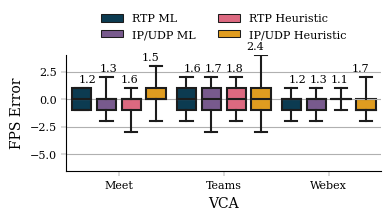

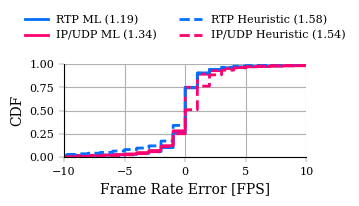

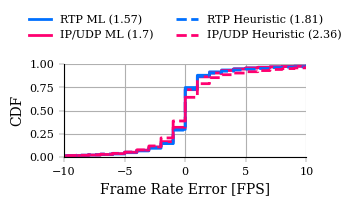

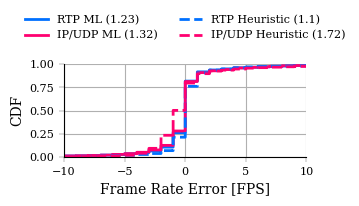

In [80]:
fig = plt.figure(figsize=(1.3*3.125, 1.5*1.0))
df['VCA'] = df['VCA'].replace({'meet': 'Meet', 'teams': 'Teams', 'webex': 'Webex'})
df_fps = df[(df['metric'] == 'framesReceivedPerSecond')]
df_fps = df_fps.rename(columns={'method': 'Method'})
medians = df_fps.groupby(['VCA', 'Method'])['deviation'].quantile(0.9).values
maes = df_fps.groupby(['VCA', 'Method'])['abs_deviation'].mean().values
maes = [str(round(x, 1)) for x in maes]
g = sns.boxplot(data=df_fps, x = 'VCA', y = 'deviation', hue='Method', showfliers=False, whis=[10, 90], width=0.95, palette=['#003f5c','#7a5195', '#ef5675','#ffa600'])
ind = 0
adjust_box_widths(fig, 0.8)
for tick in range(len(g.get_xticklabels())):
    g.text(tick+.3, medians[ind]+.5, maes[ind],  horizontalalignment='center',  color='k', weight='regular', fontsize=8)
    g.text(tick-.1, medians[ind+1]+.5, maes[ind+1], horizontalalignment='center', color='k', weight='regular', fontsize=8)
    g.text(tick+.1, medians[ind+2]+.5, maes[ind+2], horizontalalignment='center', color='k', weight='regular', fontsize=8)
    g.text(tick-.3, medians[ind+3]+.5, maes[ind+3], horizontalalignment='center', color='k', weight='regular', fontsize=8)
    ind += 4 
plt.xlabel('VCA', fontsize=10)
plt.ylabel('FPS Error', fontsize=10)
plt.legend( loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False, title="", prop={"size": 8})
# plt.grid()
plt.gca().yaxis.grid(True)
plt.savefig('paper_plots/fps_error_boxplot_imc_lab.pdf', bbox_inches='tight')
# plt.xlim([-0.5, 2])
plt.ylim([-6.5, 4])
plot_fps(df_fps, 'Meet')
plot_fps(df_fps, 'Teams')
plot_fps(df_fps, 'Webex')

In [81]:
df_meet = df_fps[(df_fps['Method'] == 'IP/UDP ML') & (df_fps['VCA'] == 'Meet')]
df_teams = df_fps[(df_fps['Method'] == 'IP/UDP ML') & (df_fps['VCA'] == 'Teams')]
df_webex = df_fps[(df_fps['Method'] == 'IP/UDP ML') & (df_fps['VCA'] == 'Webex')]

print(100*len(df_meet[(df_meet['deviation'] >= -2)&(df_meet['deviation'] <= 2)])/len(df_meet))
print(100*len(df_teams[(df_teams['deviation'] >= -2)&(df_teams['deviation'] <= 2)])/len(df_teams))
print(100*len(df_webex[(df_webex['deviation'] >= -2)&(df_webex['deviation'] <= 2)])/len(df_webex))

86.45670826833073
79.9286106534871
85.62181406262643


In [82]:
def plot_bitrate(df_bitrate, vca):
    meet = df_bitrate[df_bitrate['VCA'] == vca]
    labels = []
    llabels = {}
    for txt in suffix_map.keys():
        d = meet[meet['Method'] == txt]
        mae = round(mean_absolute_error(d['Prediction'], d['Ground Truth'])/1000, 2)
        d['Method'] = d['Method'].map({txt: txt + f" ({mae})"})
        labels.append(d)
        llabels[txt] =  txt + f" ({mae})"
    meet = pd.concat(labels, axis=0)
    fig, ax = plt.subplots(1, 1)
    sns.ecdfplot(meet[meet['Method'].str.contains('RTP ML')], x = 'rel_deviation', ls=None, color=colors[0], ax=ax, label=llabels['RTP ML'], linewidth=2)
    sns.ecdfplot(meet[meet['Method'].str.contains('IP/UDP ML')], x = 'rel_deviation', ls=None, color=colors[1], ax=ax, label=llabels['IP/UDP ML'], linewidth=2)
    sns.ecdfplot(meet[meet['Method'].str.contains('RTP Heuristic')], x = 'rel_deviation', ls='--', color=colors[0], ax=ax, label=llabels['RTP Heuristic'], linewidth=2)
    sns.ecdfplot(meet[meet['Method'].str.contains('IP/UDP Heuristic')], x = 'rel_deviation', ls='--', color=colors[1], ax=ax, label=llabels['IP/UDP Heuristic'], linewidth=2)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False, title="", prop={'size': 8})
    plt.grid(visible=1)
    plt.xlim([-1, 1])
    plt.xlabel('Relative Bitrate Error', fontsize=10)
    plt.ylabel('CDF', fontsize=10)
    plt.savefig(f'paper_plots/{vca}_bitrate_error_imc_lab.pdf', bbox_inches='tight')

Index(['Prediction', 'Ground Truth', 'timestamp', 'pcap_file', 'dataset', 'cross_val', 'metric', 'Method', 'VCA', 'deviation', 'abs_deviation', 'ts', 'ssrc', 'lastPacketReceivedTimestamp', 'framesPerSecond', 'bitrate', '[codec]', 'packetsLost', 'framesDropped', 'framesReceived', 'framesReceivedPerSecond', 'frame_jitter', 'nackCount', 'packetsReceived', 'trackIdentifier', 'freezeCount', 'totalFreezesDuration', 'pauseCount', 'totalPausesDuration', 'jitterBufferDelay', 'framesDecodedPerSecond', 'jitterBufferEmittedCount', 'frameHeight', 'qpSum', 'duration', 'num_vals', 'csv_file', 'webrtc_file', 'rel_deviation'], dtype='object')


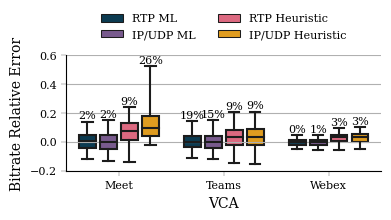

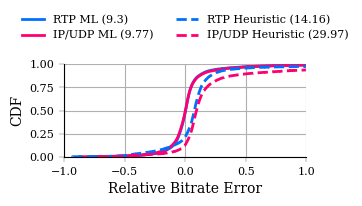

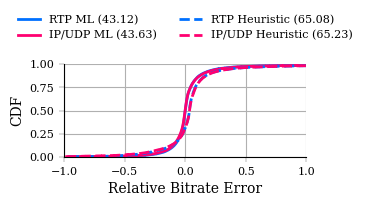

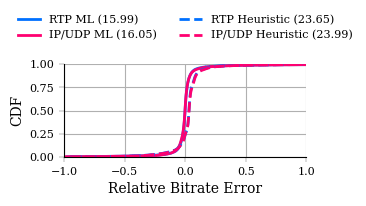

In [85]:
fig = plt.figure(figsize=(1.3*3.125, 1.5*1.0))
df_bitrate = df[(df['metric'] == 'bitrate')]
df_bitrate['deviation'] /= 1000
df_bitrate['rel_deviation'] = 1000 * df_bitrate['deviation'] / df_bitrate['Ground Truth']
df_bitrate = df_bitrate.rename(columns={'method': 'Method'})
df_bitrate.replace([np.inf, -np.inf], np.nan, inplace=True)
df_bitrate['rel_deviation'].dropna(inplace=True)

print(df_bitrate.columns)

medians = df_bitrate.groupby(['VCA', 'Method'])['rel_deviation'].quantile(0.9).values
maes = df_bitrate.groupby(['VCA', 'Method'])['rel_deviation'].mean().mul(100).values
maes = [str(round(x))+"%" for x in maes]
g = sns.boxplot(data=df_bitrate, x = 'VCA', y = 'rel_deviation', hue='Method', showfliers=False, whis=[10, 90], palette=['#003f5c','#7a5195', '#ef5675','#ffa600'])
ind = 0
adjust_box_widths(fig, 0.8)
for tick in range(len(g.get_xticklabels())):
    g.text(tick+.3, medians[ind]+.02, maes[ind],  horizontalalignment='center',  color='k', weight='regular', fontsize=8)
    g.text(tick-.1, medians[ind+1]+.02, maes[ind+1], horizontalalignment='center', color='k', weight='regular', fontsize=8)
    g.text(tick+.1, medians[ind+2]+.02, maes[ind+2], horizontalalignment='center', color='k', weight='regular', fontsize=8)
    g.text(tick-.3, medians[ind+3]+.02, maes[ind+3], horizontalalignment='center', color='k', weight='regular', fontsize=8)
    ind += 4 
plt.xlabel('VCA', fontsize=10)
plt.ylabel('Bitrate Relative Error', fontsize=10)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False, title="", prop={"size": 8})
plt.gca().yaxis.grid(True)
plt.ylim([-0.2, 0.6])
plt.savefig('paper_plots/bitrate_error_boxplot_imc_lab.pdf', bbox_inches='tight')
plot_bitrate(df_bitrate, 'Meet')
plot_bitrate(df_bitrate, 'Teams')
plot_bitrate(df_bitrate, 'Webex')

In [56]:
df_meet = df_bitrate[(df_bitrate['Method'] == 'IP/UDP ML') & (df_bitrate['VCA'] == 'Meet')]
df_teams = df_bitrate[(df_bitrate['Method'] == 'IP/UDP ML') & (df_bitrate['VCA'] == 'Teams')]
df_webex = df_bitrate[(df_bitrate['Method'] == 'IP/UDP ML') & (df_bitrate['VCA'] == 'Webex')]
print(100*len(df_meet[(df_meet['deviation'] >= -50)&(df_meet['deviation'] <= 50)])/len(df_meet))
print(100*len(df_teams[(df_teams['deviation'] >= -50)&(df_teams['deviation'] <= 50)])/len(df_teams))
print(100*len(df_webex[(df_webex['deviation'] >= -50)&(df_webex['deviation'] <= 50)])/len(df_webex))

96.850624024961
76.20812740252609
93.68071850473339


In [57]:
print(100*len(df_meet[(df_meet['rel_deviation'] >= -0.25)&(df_meet['rel_deviation'] <= 0.25)])/len(df_meet))
print(100*len(df_teams[(df_teams['rel_deviation'] >= -0.25)&(df_teams['rel_deviation'] <= 0.25)])/len(df_teams))
print(100*len(df_webex[(df_webex['rel_deviation'] >= -0.25)&(df_webex['rel_deviation'] <= 0.25)])/len(df_webex))

87.25624024960999
89.5730367929709
94.95913908892305


In [58]:
df_meet = df_bitrate[(df_bitrate['Method'] == 'RTP ML') & (df_bitrate['VCA'] == 'Meet')]
df_teams = df_bitrate[(df_bitrate['Method'] == 'RTP ML') & (df_bitrate['VCA'] == 'Teams')]
df_webex = df_bitrate[(df_bitrate['Method'] == 'RTP ML') & (df_bitrate['VCA'] == 'Webex')]
print(100*len(df_meet[(df_meet['rel_deviation'] >= -0.25)&(df_meet['rel_deviation'] <= 0.25)])/len(df_meet))
print(100*len(df_teams[(df_teams['rel_deviation'] >= -0.25)&(df_teams['rel_deviation'] <= 0.25)])/len(df_teams))
print(100*len(df_webex[(df_webex['rel_deviation'] >= -0.25)&(df_webex['rel_deviation'] <= 0.25)])/len(df_webex))

89.5989727380482
91.38472270666202
95.25511862203444


In [59]:
def plot_jitter(df_jitter, vca):
    meet = df_jitter[df_jitter['VCA'] == vca]
    labels = []
    llabels = {}
    for txt in suffix_map.keys():
        d = meet[meet['Method'] == txt]
        mae = round(mean_absolute_error(d['Prediction'], d['Ground Truth']), 2)
        d['Method'] = d['Method'].map({txt: txt + f" ({mae})"})
        labels.append(d)
        llabels[txt] =  txt + f" ({mae})"
    meet = pd.concat(labels, axis=0)
    fig, ax = plt.subplots(1, 1)
    sns.ecdfplot(meet[meet['Method'].str.contains('RTP ML')], x = 'deviation', ls=None, color=colors[0], ax=ax, label=llabels['RTP ML'], linewidth=2)
    sns.ecdfplot(meet[meet['Method'].str.contains('IP/UDP ML')], x = 'deviation', ls=None, color=colors[1], ax=ax, label=llabels['IP/UDP ML'], linewidth=2)
    sns.ecdfplot(meet[meet['Method'].str.contains('RTP Heuristic')], x = 'deviation', ls='--', color=colors[0], ax=ax, label=llabels['RTP Heuristic'], linewidth=2)
    sns.ecdfplot(meet[meet['Method'].str.contains('IP/UDP Heuristic')], x = 'deviation', ls='--', color=colors[1], ax=ax, label=llabels['IP/UDP Heuristic'], linewidth=2)
    plt.legend( loc='lower center', bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False, title="", prop={'size': 8})
    plt.grid(visible=1)
    plt.xlim([-100, 100])
    plt.xlabel('Frame Jitter Error [ms]', fontsize=10)
    plt.ylabel('CDF', fontsize=10)
    plt.savefig(f'paper_plots/{vca}_jitter_error_imc_lab.pdf', bbox_inches='tight')

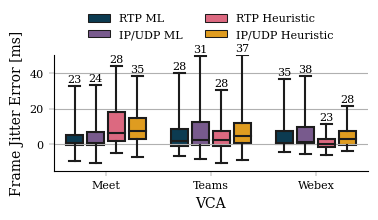

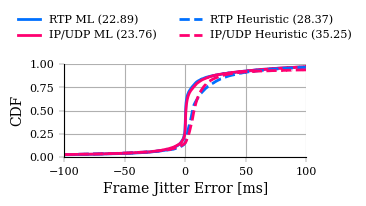

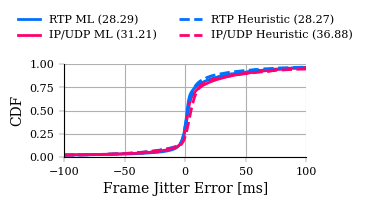

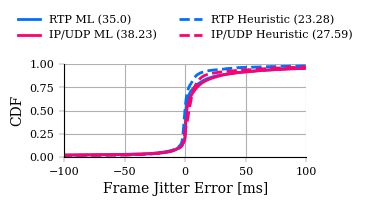

In [60]:
fig = plt.figure(figsize=(1.3*3.125, 1.5*1.0))
df_jitter = df[(df['metric'] == 'frame_jitter')]
df_jitter = df_jitter.rename(columns={'method': 'Method'})
medians = df_jitter.groupby(['VCA', 'Method'])['deviation'].quantile(0.9).values
maes = df_jitter.groupby(['VCA', 'Method'])['abs_deviation'].mean().values
maes = [str(round(x)) for x in maes]
g = sns.boxplot(data=df_jitter, x = 'VCA', y = 'deviation', hue='Method', showfliers=False, whis=[10, 90], palette=['#003f5c','#7a5195', '#ef5675','#ffa600'])
ind = 0
adjust_box_widths(fig, 0.8)
for tick in range(len(g.get_xticklabels())):
    g.text(tick+.3, medians[ind]+2, maes[ind],  horizontalalignment='center',  color='k', weight='regular', fontsize=8)
    g.text(tick-.1, medians[ind+1]+2, maes[ind+1], horizontalalignment='center', color='k', weight='regular', fontsize=8)
    g.text(tick+.1, medians[ind+2]+2, maes[ind+2], horizontalalignment='center', color='k', weight='regular', fontsize=8)
    g.text(tick-.3, medians[ind+3]+2, maes[ind+3], horizontalalignment='center', color='k', weight='regular', fontsize=8)
    ind += 4 
plt.ylim([-15, 50])
plt.xlabel('VCA', fontsize=10)
plt.ylabel('Frame Jitter Error [ms]', fontsize=10)
plt.legend( loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False, title="", prop={"size": 8})
plt.gca().yaxis.grid(True)
plt.savefig('paper_plots/jitter_error_boxplot_imc_lab.pdf', bbox_inches='tight')
plot_jitter(df_jitter, 'Meet')
plot_jitter(df_jitter, 'Teams')
plot_jitter(df_jitter, 'Webex')

In [99]:
df_jitter.groupby('VCA')['Ground Truth'].mean()

VCA
Meet    29.75
Teams   33.05
Webex   27.10
Name: Ground Truth, dtype: float64

52.019568948476405


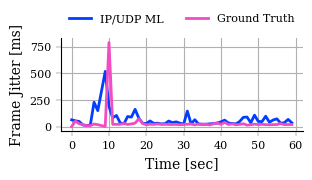

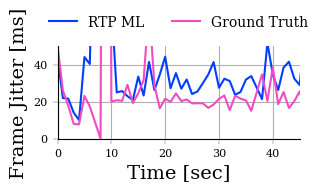

<Figure size 312.5x120 with 0 Axes>

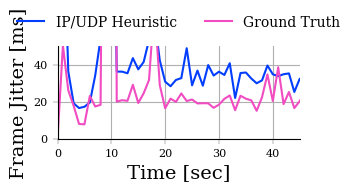

<Figure size 312.5x120 with 0 Axes>

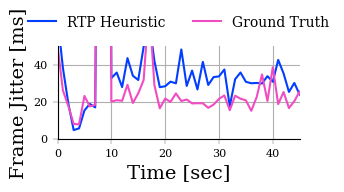

In [61]:
teams = df_jitter[df_jitter['VCA'] == 'Teams']
csv_file = teams['csv_file'].iloc[100]
tdf = teams[(teams['csv_file'] == csv_file)&(teams['Method'].str.contains('IP/UDP ML'))].sort_values(by='ts')
print(tdf['abs_deviation'].mean())
tdf['ts'] = tdf['ts'] - tdf['ts'].min()
fig, ax = plt.subplots(1, 1)
tdf.plot('ts', 'Prediction', ax=ax, label=f'IP/UDP ML', color = '#023eff', linewidth=2)
tdf.plot('ts', 'Ground Truth', ax=ax, label='Ground Truth', color= '#f14cc1', linewidth=2)
plt.grid(visible=1)
plt.xlabel('Time [sec]', fontsize=10)
plt.ylabel('Frame Jitter [ms]', fontsize=10)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False,prop={'size': 8})
# plt.ylim([0, 50])
# plt.xlim([0, 45])
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('paper_plots/frame_jitter_ip_udp_ml.pdf', bbox_inches='tight')
fig, ax = plt.subplots(1, 1)
tdf = teams[(teams['csv_file'] == csv_file)&(teams['Method'].str.contains('RTP ML'))].sort_values(by='ts')
tdf['ts'] = tdf['ts'] - tdf['ts'].min()
tdf.plot('ts', 'Prediction', ax=ax, label=f'RTP ML', color = '#023eff')
tdf.plot('ts', 'Ground Truth', ax=ax, label='Ground Truth', color= '#f14cc1')
plt.grid(visible=1)
plt.xlabel('Time [sec]')
plt.ylabel('Frame Jitter [ms]')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False)
plt.ylim([0, 50])
plt.xlim([0, 45])
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('paper_plots/frame_jitter_rtp_ml.pdf', bbox_inches='tight')
plt.figure()
fig, ax = plt.subplots(1, 1)
tdf = teams[(teams['csv_file'] == csv_file) & (teams['Method'].str.contains('IP/UDP Heuristic'))].sort_values(by='ts')
tdf['ts'] = tdf['ts'] - tdf['ts'].min()
tdf.plot('ts', 'Prediction', ax=ax, label=f'IP/UDP Heuristic', color = '#023eff')
tdf.plot('ts', 'Ground Truth', ax=ax, label='Ground Truth', color= '#f14cc1')
plt.grid(visible=1)
plt.xlabel('Time [sec]')
plt.ylabel('Frame Jitter [ms]')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False)
plt.ylim([0, 50])
plt.xlim([0, 45])
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('paper_plots/frame_jitter_ip_udp_non_ml.pdf', bbox_inches='tight')
plt.figure()
fig, ax = plt.subplots(1, 1)
tdf = teams[(teams['csv_file'] == csv_file)&(teams['Method'].str.contains('RTP Heuristic'))].sort_values(by='ts')
tdf['ts'] = tdf['ts'] - tdf['ts'].min()
tdf.plot('ts', 'Prediction', ax=ax, label=f'RTP Heuristic', color = '#023eff')
tdf.plot('ts', 'Ground Truth', ax=ax, label='Ground Truth', color= '#f14cc1')
plt.grid(visible=1)
plt.xlabel('Time [sec]')
plt.ylabel('Frame Jitter [ms]')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False)
plt.ylim([0, 50])
plt.xlim([0, 45])
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('paper_plots/frame_jitter_rtp_non_ml.pdf', bbox_inches='tight')

# Resolution Confusion Matrices

[180.0, 270.0, 360.0]
Meet
[9069  275  780]
[90.0, 116.0, 134.0, 176.0, 180.0, 234.0, 270.0, 360.0, 404.0, 540.0, 720.0]
Teams
[4971 1780 7576]
[180.0, 360.0]
Webex
[   92 12199]


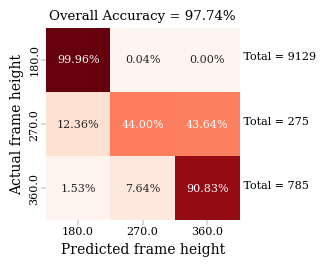

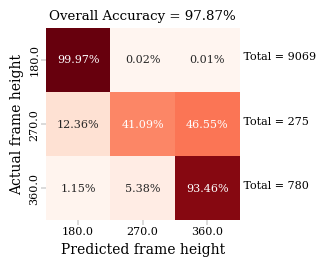

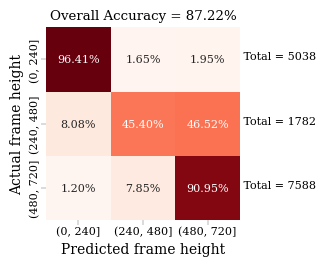

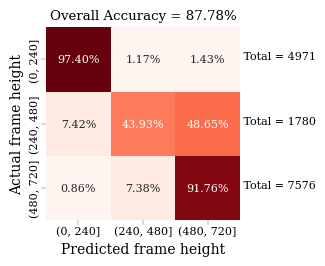

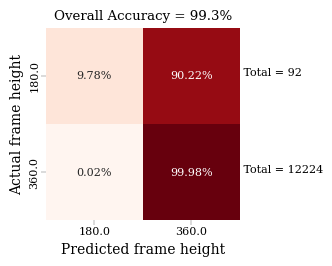

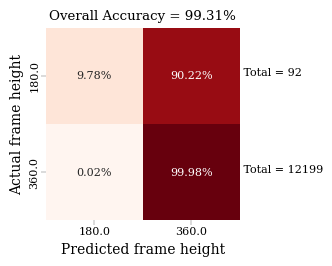

In [62]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

df_frameHeight = df[(df['metric'] == 'frameHeight')]

def bin_res(x):
    if x > 0 and x <= 240:
        return "(0, 240]"
    elif x > 240 and x <= 480:
        return "(240, 480]"
    elif x > 480 and x <= 720:
        return "(480, 720]"

for vca in ['Meet', 'Teams', 'Webex']:
    teams = df_frameHeight[df_frameHeight['VCA'] == vca]
    print(sorted(teams["Ground Truth"].unique()))
    if vca == 'Teams':
        teams["Prediction"] = teams["Prediction"].apply(bin_res)
        teams["Ground Truth"] = teams["Ground Truth"].apply(bin_res)
    print(vca)
    fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
    udp = teams[teams['method'] == 'IP/UDP ML']
    labels=sorted(list(udp['Ground Truth'].unique()))
    ccounts = np.unique(udp['Ground Truth'], return_counts=True)[1]
    cperc = ccounts / len(udp['Ground Truth'])
    cm = confusion_matrix(y_pred=udp['Prediction'], y_true=udp['Ground Truth'], labels=labels)
    f1 = round(100*accuracy_score(udp['Prediction'], udp['Ground Truth']), 2)
    cm_norm = 100*cm / cm.sum(axis=1, keepdims=True)
    cm_norm[np.isnan(cm_norm)] = 0
    total = cm.sum(axis=1, keepdims=True).flatten()
    p = len(total)
    formatted_text = np.asarray(["{0:.2f}%".format(a) for a in cm_norm.flatten()]).reshape(cm.shape[0], cm.shape[1])
    sns.heatmap(cm_norm, annot=formatted_text, cmap='Reds', fmt='', xticklabels=labels, yticklabels=labels, cbar=False, ax=ax)
    i = 0
    for x,y in zip(total, ccounts):
        plt.annotate(f" Total = {y}", xy=(p, i+0.5))
        i += 1
    ax.tick_params(pad=1)
    ax.set_title(f'Overall Accuracy = {f1}%')
    ax.set_ylabel('Actual frame height', fontsize=10)
    ax.set_xlabel('Predicted frame height', fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    plt.savefig(f'paper_plots/{vca}_resolution_cm_imc_lab_ip.pdf', bbox_inches='tight')

    fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
    rtp = teams[teams['method'] == 'RTP ML']
    labels=sorted(list(rtp['Ground Truth'].unique()))
    ccounts = np.unique(rtp['Ground Truth'], return_counts=True)[1]
    print(ccounts)
    cperc = ccounts / len(rtp['Ground Truth'])
    cm = confusion_matrix(y_pred=rtp['Prediction'], y_true=rtp['Ground Truth'], labels=labels)
    f1 = round(100*accuracy_score(rtp['Prediction'], rtp['Ground Truth']), 2)
    cm_norm = 100*cm / cm.sum(axis=1, keepdims=True)
    cm_norm[np.isnan(cm_norm)] = 0
    total = cm.sum(axis=1, keepdims=True).flatten()
    formatted_text = np.asarray(["{0:.2f}%".format(a) for a in cm_norm.flatten()]).reshape(cm.shape[0], cm.shape[1])
    sns.heatmap(cm_norm, annot=formatted_text, cmap='Reds', fmt='', xticklabels=labels, yticklabels=labels, cbar=False, ax=ax)
    i = 0
    for x,y in zip(total, ccounts):
        plt.annotate(f" Total = {y}", xy=(p, i+0.5))
        i += 1
    ax.tick_params(pad=1)
    ax.set_title(f'Overall Accuracy = {f1}%')
    ax.set_ylabel('Actual frame height', fontsize=10)
    ax.set_xlabel('Predicted frame height', fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    plt.savefig(f'paper_plots/{vca}_resolution_cm_imc_lab_rtp.pdf', bbox_inches='tight')

In [104]:
df_frameHeight[df_frameHeight['VCA'] == 'Teams']['frameHeight'].value_counts(normalize=True).mul(100)

720.00   29.29
540.00   24.59
134.00   10.52
404.00    8.47
180.00    7.72
234.00    7.71
176.00    6.90
360.00    1.90
270.00    1.84
116.00    0.84
90.00     0.24
Name: frameHeight, dtype: float64

# Feature Importance Scores

In [66]:
def plot_feature_importance(f_rtp, f_udp, metric):
    for vca in f_rtp[metric][1].keys():
        print(vca)
        scores_rtp = {}
        for cv in f_rtp[metric].keys():
            for feature in f_rtp[metric][cv][vca].keys():
                if feature_map[feature] not in scores_rtp:
                    scores_rtp[feature_map[feature]] = []
                scores_rtp[feature_map[feature]].append(100*f_rtp[metric][cv][vca][feature])
        scores_udp = {}
        for cv in f_udp[metric].keys():
            for feature in f_udp[metric][cv][vca].keys():
                if feature_map[feature] not in scores_udp:
                    scores_udp[feature_map[feature]] = []
                scores_udp[feature_map[feature]].append(100*f_udp[metric][cv][vca][feature])
                
        mmap = {'framesReceivedPerSecond': 'Frames Per Second', 'bitrate': 'Bitrate', 'frame_jitter': 'Frame Jitter', 'frameHeight': 'FrameHeight'}
        if vca == 'meet':
            vc_name = 'Meet'
        elif vca == 'teams':
            vc_name = 'Teams'
        elif vca == 'webex':
            vc_name = 'Webex'
        
        fig, ax = plt.subplots(1, 1, figsize=[1.0*3.125, 1.5*1.0])
        topk = pd.DataFrame(scores_rtp).mean().sort_values(ascending=False).head(5).sort_values()
        plt.barh(topk.index, topk.values, color=colors[5])
        plt.xlabel(f'Feature Importance [%]', fontsize=10)
        plt.ylabel('Feature', fontsize=10)
        plt.xlim([0, 100])
        plt.gca().xaxis.grid(True)
        plt.yticks(fontsize=10)
        # plt.grid(visible=1)
        ax.spines[['right', 'top']].set_visible(False)
        plt.savefig(f'paper_plots/{vca}_{metric}_rtp_ml_feature_importance_imc_lab.pdf', bbox_inches='tight')
        
        fig, ax = plt.subplots(1, 1, figsize=[1.0*3.125, 1.5*1.0])
        topk = pd.DataFrame(scores_udp).mean().sort_values(ascending=False).head(5).sort_values()
        plt.barh(topk.index, topk.values, color=colors[5])
        plt.xlabel(f'Feature Importance [%]', fontsize=10)
        plt.ylabel('Feature', fontsize=10)
        plt.xlim([0, 100])
        plt.gca().xaxis.grid(True)
        # plt.grid(visible=1)
        
        plt.yticks(fontsize=10)
        ax.spines[['right', 'top']].set_visible(False)
        plt.savefig(f'paper_plots/{vca}_{metric}_ip_udp_ml_feature_importance_imc_lab.pdf', bbox_inches='tight')

meet
teams
webex


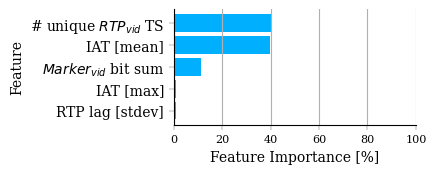

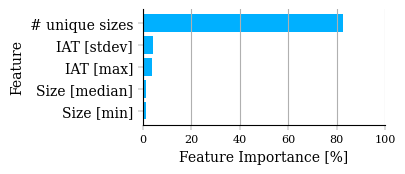

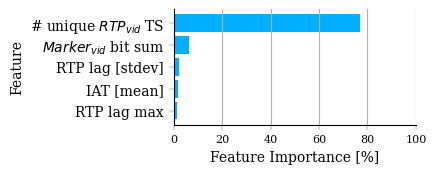

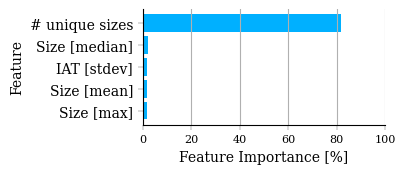

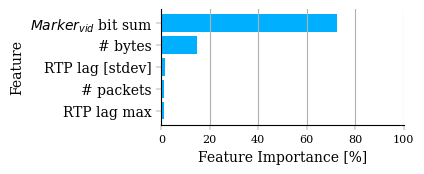

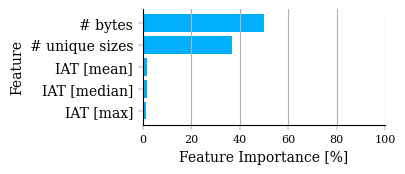

In [67]:
plot_feature_importance(f_rtp_ml, f_udp_ml, 'framesReceivedPerSecond')

meet
teams
webex


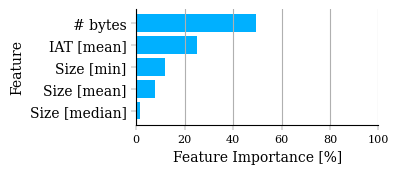

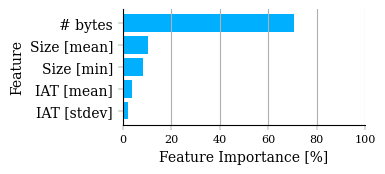

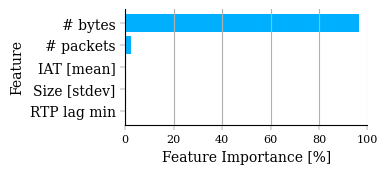

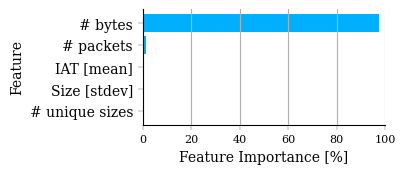

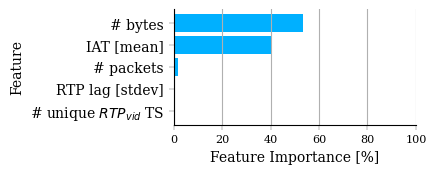

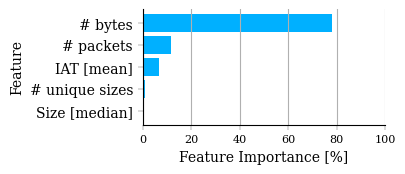

In [68]:
plot_feature_importance(f_rtp_ml, f_udp_ml, 'bitrate')

meet
teams
webex


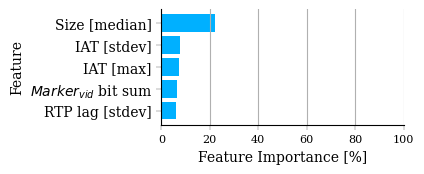

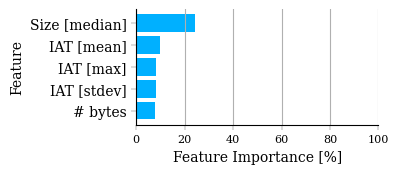

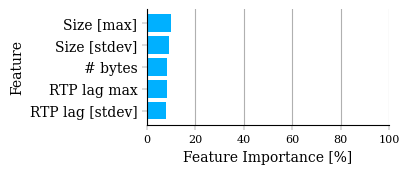

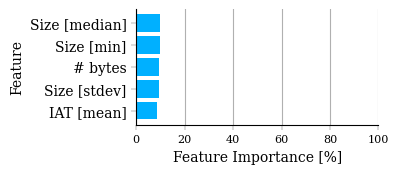

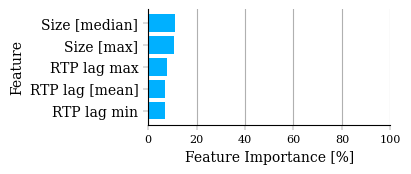

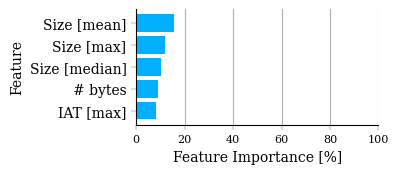

In [69]:
plot_feature_importance(f_rtp_ml, f_udp_ml, 'frame_jitter')

meet
teams
webex


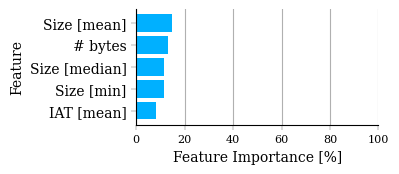

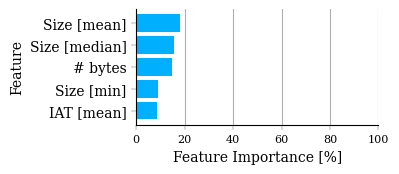

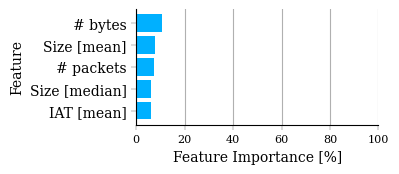

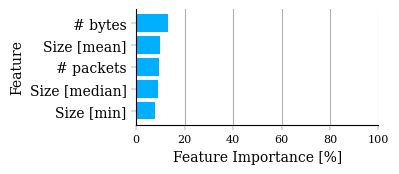

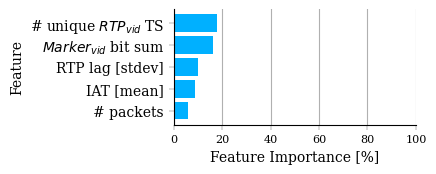

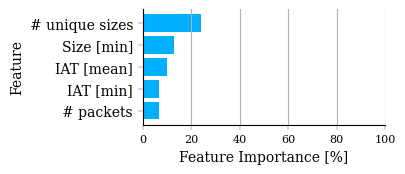

In [70]:
plot_feature_importance(f_rtp_ml, f_udp_ml, 'frameHeight')

# Ground Truth Distributions

/home/taveesh/Documents/Projects/vca-qoe-inference/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3194: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


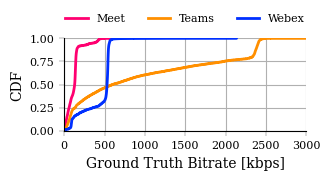

In [328]:
df = pd.read_csv('imc_lab_results.csv', index_col=None)
fig, ax = plt.subplots(1, 1)
df['bitrate_kbps'] = df['bitrate']/1000
sns.ecdfplot(data=df[df['VCA'] == 'meet'], x = 'bitrate_kbps', ax=ax, label='Meet', color=colors[1], linewidth=2)
sns.ecdfplot(data=df[df['VCA'] == 'teams'], x = 'bitrate_kbps', ax=ax, label='Teams', color=colors[-2], linewidth=2)
sns.ecdfplot(data=df[df['VCA'] == 'webex'], x = 'bitrate_kbps', ax=ax, label='Webex', color=colors[-1], linewidth=2)
plt.xlabel('Ground Truth Bitrate [kbps]', fontsize=10)
plt.ylabel('CDF', fontsize=10)
plt.grid(visible=1)
plt.xlim([0, 3000])
#add legend to plot
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False, prop={'size': 8})
plt.savefig('paper_plots/gt_bitrate_imc_lab.pdf', bbox_inches='tight')

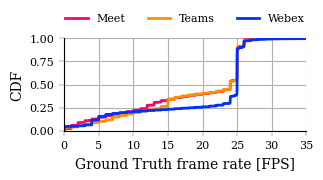

In [329]:
fig, ax = plt.subplots(1, 1)
sns.ecdfplot(data=df[df['VCA'] == 'meet'], x = 'framesReceivedPerSecond', ax=ax, label='Meet', color=colors[1], linewidth=2)
sns.ecdfplot(data=df[df['VCA'] == 'teams'], x = 'framesReceivedPerSecond', ax=ax, label='Teams', color=colors[-2], linewidth=2)
sns.ecdfplot(data=df[df['VCA'] == 'webex'], x = 'framesReceivedPerSecond', ax=ax, label='Webex', color=colors[-1], linewidth=2)
plt.xlabel('Ground Truth frame rate [FPS]', fontsize=10)
plt.ylabel('CDF', fontsize=10)
plt.grid(visible=1)
plt.xlim([0, 35])
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False, prop={'size': 8})
plt.savefig('paper_plots/gt_fps_imc_lab.pdf', bbox_inches='tight')

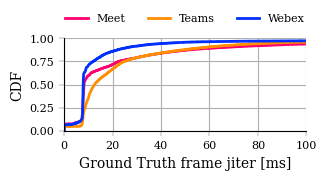

In [330]:
fig, ax = plt.subplots(1, 1)
sns.ecdfplot(data=df[df['VCA'] == 'meet'], x = 'frame_jitter', ax=ax, label='Meet', color=colors[1], linewidth=2)
sns.ecdfplot(data=df[df['VCA'] == 'teams'], x = 'frame_jitter', ax=ax, label='Teams', color=colors[-2], linewidth=2)
sns.ecdfplot(data=df[df['VCA'] == 'webex'], x = 'frame_jitter', ax=ax, label='Webex', color=colors[-1], linewidth=2)
plt.xlabel('Ground Truth frame jiter [ms]', fontsize=10)
plt.ylabel('CDF', fontsize=10)
plt.grid(visible=1)
plt.xlim([0, 100])
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False, prop={'size': 8})
plt.savefig('paper_plots/gt_jitter_imc_lab.pdf', bbox_inches='tight')

In [945]:
df[df['metric'] == 'frame_jitter']['Ground Truth'].mean()

31.265112040552445

# Lookback Tuning

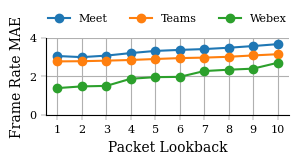

In [196]:
dm1 = pd.read_csv('meet_lookback.csv')
dt1 = pd.read_csv('teams_lookback.csv')
dw1 = pd.read_csv('webex_lookback.csv')
# dm2 = pd.read_csv('meet_lookback_imc_11_20.csv')
# dt2 = pd.read_csv('teams_lookback_imc_11_20.csv')
# dw2 = pd.read_csv('webex_lookback_imc_11_20.csv')

# dm = pd.concat((dm1, dm2), axis=0)
# dt = pd.concat((dt1, dt2), axis=0)
# dw = pd.concat((dw1, dw2), axis=0)

# print(dm.groupby('L')['MAE'].mean())
# print(dt.groupby('L')['MAE'].mean())
# print(dw.groupby('L')['MAE'].mean())
fig, ax = plt.subplots(1,1, figsize=(1.0*3.125, 1.0*1.0))
dm1.groupby('L')['MAE'].mean().plot(marker='o', ax=ax, label='Meet')
dt1.groupby('L')['MAE'].mean().plot(marker='o', ax=ax, label='Teams')
dw1.groupby('L')['MAE'].mean().plot(marker='o', ax=ax, label='Webex')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False, labels=['Meet', 'Teams', 'Webex'], prop={'size': 8})
ax.set_ylabel('Frame Rate MAE', fontsize=10)
ax.set_xlabel('Packet Lookback', fontsize=10)
# ax.set_xlim([0, 16])
ax.set_xticks(list(range(1, 11)))
ax.set_ylim([0, 4])
ax.grid(visible=1)
plt.savefig('paper_plots/lookback_tuning.pdf', bbox_inches='tight')

In [193]:
dw1.groupby('L')['MAE'].mean()

L
1    1.38
2    1.47
3    1.50
4    1.87
5    1.95
6    1.97
7    2.27
8    2.34
9    2.39
10   2.70
Name: MAE, dtype: float64

In [931]:
print(dm[(dm['L'] == 3)][['frac_interleave', 'frac_coalesce']].mean().mul(100))
print(dt[(dt['L'] == 2)][['frac_interleave', 'frac_coalesce']].mean().mul(100))
print(dw[(dw['L'] == 1)][['frac_interleave', 'frac_coalesce']].mean().mul(100))

frac_interleave   6.23
frac_coalesce     3.04
dtype: float64
frac_interleave   1.99
frac_coalesce     2.29
dtype: float64
frac_interleave   0.58
frac_coalesce     3.61
dtype: float64


# Toy Example Showing Inaccuracies

In [600]:
df_fps[df_fps['abs_deviation'] > 5]['csv_file'].iloc[137]

'/home/taveesh/Documents/Projects/vca-qoe-inference/data/IMC_Lab_data/2023-05-16_teams_3805_1108_45_21_2_48_288/teams/captures/teams-chrome-3805_1108_45_21_2_48_288-1684281948.csv'

In [16]:
csv_file = '/home/taveesh/Documents/Projects/vca-qoe-inference/data/IMC_Lab_data/2023-05-16_teams_101_24_66_1_0_41_49/teams/captures/teams-chrome-101_24_66_1_0_41_49-1684258502.csv'
net_columns = ['frame.time_relative','frame.time_epoch','ip.src','ip.dst','ip.proto','ip.len','udp.srcport','udp.dstport', 'udp.length','rtp.ssrc','rtp.timestamp','rtp.seq','rtp.p_type', 'rtp.marker']
df = pd.read_csv(csv_file, header=None, sep='\t', names=net_columns, lineterminator='\n', encoding='ascii')
dfg = df.groupby('rtp.timestamp').agg(max_size=('udp.length', max), min_size = ('udp.length', min)).reset_index()
if df['ip.proto'].dtype == object:
    df = df[df['ip.proto'].str.contains(',') == False]
df = df[~df['ip.proto'].isna()]
df['ip.proto'] = df['ip.proto'].astype(int)
df = df[(df['ip.proto'] == 17) & (df['ip.dst'] == '192.168.1.187')]
src = df.groupby('ip.src').agg({'udp.length': sum, 'rtp.p_type': 'count'}).reset_index().sort_values(by='udp.length', ascending=False).head(1)['ip.src'].iloc[0]
df = df[df['ip.src'] == src]

df = df[df['udp.length'] > 306]
df = df.sort_values(by=['frame.time_relative'])
frame_id_assignment = [-1 for _ in range(df.shape[0])]
frame_id = 1
l = 2
for i in range(df.shape[0]):
    found = False
    s = df.iloc[i]['udp.length']
    for j in range(i-1, max(0, i-l-1), -1):
        if abs(df.iloc[j]['udp.length'] - s) <= 2:
            frame_id_assignment[i] = frame_id
            found = True
            break
    if not found:
        frame_id += 1
        frame_id_assignment[i] = frame_id
df["frame_num"] = frame_id_assignment
dfc = df.groupby("frame_num").agg({"rtp.timestamp": (lambda x: len(set(x)))})
coal = len(dfc[dfc["rtp.timestamp"] > 1]) / len(dfc)
dfi = df.groupby("rtp.timestamp").agg({"frame_num": (lambda x: len(set(x)))})
il = len(dfi[dfi["frame_num"] > 1]) / len(dfi)

6 4


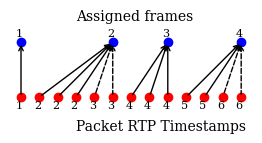

In [18]:
matplotlib.rcParams.update({'font.size': 8, 'figure.figsize' : [1.0*3.125, 1.0],
                           'legend.fontsize': 10, 'legend.fancybox': True,
                           'font.family': 'serif', 'font.sans-serif': 'Times',
                            'xtick.major.width': 0.2, 'xtick.minor.width': 2*0.2,
                            'ytick.major.width': 0.2, 'ytick.minor.width': 2*0.2,
                            'text.usetex': False, 'axes.labelsize': 7*2,
                            'axes.spines.right': False, 'axes.spines.top': False
                           })
from collections import defaultdict
df['et'] = df['frame.time_relative'].apply(int)
dfs = df[(df['et'] == 30)]
rtps = dfs['rtp.timestamp'].tolist()
fnums = dfs['frame_num'].tolist()
times = dfs['frame.time_relative'].tolist()
rtp_set = sorted(list(set(rtps)))
fnum_set = sorted(list(set(fnums)))
print(len(rtp_set), len(fnum_set))
rtp_idx = {rtp_set[i]: i for i in range(len(rtp_set))}
fnum_idx = {fnum_set[i]: i for i in range(len(fnum_set))}
rel = [(i, fnum_idx[fnums[i]]) for i in range(len(rtps))]
max_idx = defaultdict(lambda: -1)
for a, b in rel:
    max_idx[b] = max(max_idx[b], a)
top_x = [max_idx[x] for x in max_idx.keys()]
a_y_ = sorted(rtps)
b_y_ = sorted(fnums)
a_y = [rtp_idx[x] for x in a_y_]
b_y = [fnum_idx[x] for x in b_y_]
a_x = [1 for i in range(len(a_y))]
b_x = [2 for i in range(len(fnum_idx))]
plt.figure()
plt.scatter(list(range(len(a_y))), a_x, c='r')
plt.scatter(top_x, b_x, c='b')
plt.margins(y=0.2)
for i in range(len(rtps)):
    plt.annotate(xy=(i-0.3, 0.8), text=f'{rtp_idx[rtps[i]]+1}', fontsize=8)
for i in range(len(fnum_idx)):
    plt.annotate(xy=(max_idx[i]-0.3, 2+0.1), text=f'{i+1}', fontsize=8)
for i1, i2 in rel:
    if i1 in [4, 5, 11, 12]:
        plt.annotate(xy=(i1,1), xytext=(max_idx[i2], 2), arrowprops=dict(arrowstyle='<-', ls = '--') , text='')
    else:
        plt.annotate(xy=(i1,1), xytext=(max_idx[i2], 2), arrowprops=dict(arrowstyle='<-') , text='')
plt.text(x =3, y = 0.4, s = 'Packet RTP Timestamps', fontsize=10)
plt.text(x =3, y = 2.4, s = 'Assigned frames', fontsize=10)
plt.yticks([])
plt.xticks([])
plt.box(False)
plt.savefig('paper_plots/coalesces.pdf', bbox_inches='tight')

In [934]:
dfs

,frame.time_relative,frame.time_epoch,ip.src,ip.dst,ip.proto,ip.len,udp.srcport,udp.dstport,udp.length,rtp.ssrc,rtp.timestamp,rtp.seq,rtp.p_type,rtp.marker,frame_num,et
2608,30.02,1684258532.99,52.113.209.76,192.168.1.187,17,912,3480.00,47988.00,892.00,0x00009d3a,337776537.00,18842.00,102.00,1.00,104,30
2611,30.11,1684258533.09,52.113.209.76,192.168.1.187,17,1041,3480.00,47988.00,1021.00,0x00009d3a,337779614.00,18843.00,102.00,0.00,105,30
2613,30.19,1684258533.17,52.113.209.76,192.168.1.187,17,1041,3480.00,47988.00,1021.00,0x00009d3a,337779614.00,18844.00,102.00,0.00,105,30
2617,30.27,1684258533.25,52.113.209.76,192.168.1.187,17,1042,3480.00,47988.00,1022.00,0x00009d3a,337779614.00,18845.00,102.00,1.00,105,30
2620,30.35,1684258533.33,52.113.209.76,192.168.1.187,17,1040,3480.00,47988.00,1020.00,0x00009d3a,337783708.00,18846.00,102.00,0.00,105,30
2622,30.43,1684258533.41,52.113.209.76,192.168.1.187,17,1040,3480.00,47988.00,1020.00,0x00009d3a,337783708.00,18847.00,102.00,1.00,105,30
2624,30.51,1684258533.49,52.113.209.76,192.168.1.187,17,1028,3480.00,47988.00,1008.00,0x00009d3a,337786341.00,18848.00,102.00,0.00,106,30
2626,30.59,1684258533.57,52.113.209.76,192.168.1.187,17,1028,3480.00,47988.00,1008.00,0x00009d3a,337786341.00,18849.00,102.00,0.00,106,30
2628,30.67,1684258533.65,52.113.209.76,192.168.1.187,17,1028,3480.00,47988.00,1008.00,0x00009d3a,337786341.00,18850.00,102.00,1.00,106,30
2631,30.75,1684258533.73,52.113.209.76,192.168.1.187,17,1032,3480.00,47988.00,1012.00,0x00009d3a,337790599.00,18851.00,102.00,0.00,107,30


# Frame length and size range distribution

/home/taveesh/Documents/Projects/vca-qoe-inference/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3194: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/tmp/ipykernel_2990040/1382651251.py:16: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.ecdfplot(data=m_comb, x = 'udp.length', hue='Dataset', hue_order=['In-Lab', 'Real World'], linewidth=2, palette=sns.color_palette('bright6'))


meet 3.0
meet 4.0
0.8140382942841123


/tmp/ipykernel_2990040/1382651251.py:28: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.ecdfplot(data=m_comb, x = 'frame.time_epoch', hue='Dataset', hue_order=['In-Lab', 'Real World'], linewidth=2, palette=sns.color_palette('bright6'))


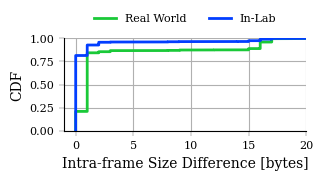

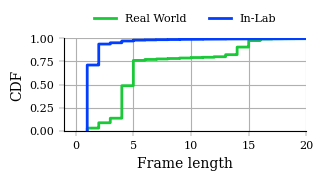

In [28]:
res = pd.read_csv('imc_lab_results.csv')
res = res[(res['metric'] == 'framesReceivedPerSecond') & (res['method'] == 'IP/UDP Heuristic') & (res['VCA'] == 'meet')]
csv_files = list(res['csv_file'].unique())
net_columns = ['frame.time_relative','frame.time_epoch','ip.src','ip.dst','ip.proto','ip.len','udp.srcport','udp.dstport', 'udp.length','rtp.ssrc','rtp.timestamp','rtp.seq','rtp.p_type', 'rtp.marker']
data = []
for wcsv in csv_files:
    m = pd.read_csv(wcsv, header=None, sep='\t', names=net_columns, lineterminator='\n', encoding='ascii').sort_values(by='frame.time_relative')
    m = m[(~m['rtp.ssrc'].isna()) & (m['udp.length'] > 306) & (m['ip.dst'] == '192.168.1.187')]
    data.append(m.groupby('rtp.timestamp').agg({'udp.length': lambda x: max(x) - min(x), 'frame.time_epoch': len}).reset_index())
m = pd.concat(data, axis=0)
plt.figure()
m1 = pd.read_csv('meet_intra_diff_netrics.csv', index_col=None)
m['Dataset'] = 'In-Lab'
m1['Dataset'] = 'Real World'
m_comb = pd.concat([m, m1], axis=0)
sns.ecdfplot(data=m_comb, x = 'udp.length', hue='Dataset', hue_order=['In-Lab', 'Real World'], linewidth=2, palette=sns.color_palette('bright6'))
plt.xlim([-1, 20])
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False, prop={'size': 8}, title="", labels=['In-Lab', 'Real World'][::-1])
# plt.xticks(np.arange(21))
plt.xlabel('Intra-frame Size Difference [bytes]', fontsize=10)
plt.ylabel('CDF', fontsize=10)
plt.grid()
plt.savefig('paper_plots/in_lab_vs_rw_delta.pdf', bbox_inches='tight')
print('meet', m['udp.length'].quantile(0.96))
print('meet', m['frame.time_epoch'].quantile(0.96))
print(m[m['udp.length'] == 0].shape[0] / m.shape[0])
plt.figure()
sns.ecdfplot(data=m_comb, x = 'frame.time_epoch', hue='Dataset', hue_order=['In-Lab', 'Real World'], linewidth=2, palette=sns.color_palette('bright6'))
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False, prop={'size': 8}, title="", labels=['In-Lab', 'Real World'][::-1])
plt.xlim([-1, 20])
plt.xlabel('Frame length', fontsize=10)
plt.ylabel('CDF', fontsize=10)
# plt.xticks(np.arange(11))
plt.grid()

In [30]:
100*m_comb[(m_comb['Dataset'] == 'In-Lab') & (m_comb['udp.length'] > 2)].shape[0] / m_comb[(m_comb['Dataset'] == 'In-Lab')].shape[0]

4.265172686295026

In [34]:
100*m_comb[(m_comb['Dataset'] == 'Real World') & (m_comb['udp.length'] > 2)].shape[0] / m_comb[(m_comb['Dataset'] == 'Real World')].shape[0]

14.480999825759136

In [1138]:
print(100*m[m['udp.length'] <= 2].shape[0] / m.shape[0])
print(100*m[m['frame.time_epoch'] < 4].shape[0] / m.shape[0])

95.73482731370497
95.18076544419868


teams 1.0
teams 13.0


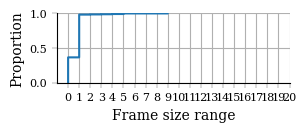

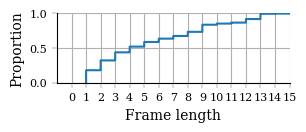

In [1135]:
res = pd.read_csv('imc_lab_results.csv')
res = res[(res['metric'] == 'framesReceivedPerSecond') & (res['method'] == 'IP/UDP Heuristic') & (res['VCA'] == 'teams')]
csv_files = list(res['csv_file'].unique())[:100]
net_columns = ['frame.time_relative','frame.time_epoch','ip.src','ip.dst','ip.proto','ip.len','udp.srcport','udp.dstport', 'udp.length','rtp.ssrc','rtp.timestamp','rtp.seq','rtp.p_type', 'rtp.marker']
data = []
for wcsv in csv_files:
    m = pd.read_csv(wcsv, header=None, sep='\t', names=net_columns, lineterminator='\n', encoding='ascii').sort_values(by='frame.time_relative')
    m = m[(~m['rtp.ssrc'].isna()) & (m['udp.length'] > 306) & (m['ip.dst'] == '192.168.1.187')]
    data.append(m.groupby('rtp.timestamp').agg({'udp.length': lambda x: max(x) - min(x), 'frame.time_epoch': len}).reset_index())
m = pd.concat(data, axis=0)
plt.figure()
sns.ecdfplot(data=m, x = 'udp.length')
plt.xlim([-1, 20])
plt.xticks(np.arange(21))
plt.xlabel('Frame size range')
plt.grid()
print('teams', m['udp.length'].quantile(0.96))
print('teams', m['frame.time_epoch'].quantile(0.96))
plt.figure()
sns.ecdfplot(data=m, x = 'frame.time_epoch')
plt.xlim([-1, 15])
plt.xlabel('Frame length')
plt.xticks(np.arange(16))
plt.grid()

In [1136]:
print(100*m[m['udp.length'] <= 2].shape[0] / m.shape[0])
print(100*m[m['frame.time_epoch'] < 4].shape[0] / m.shape[0])

98.56872831228429
43.82681800656391


webex 2.0
webex 3.0


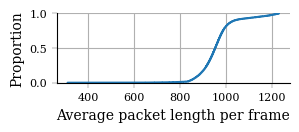

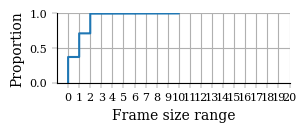

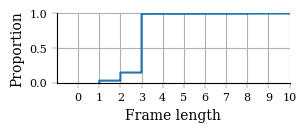

In [1133]:
res = pd.read_csv('imc_lab_results.csv')
res = res[(res['metric'] == 'framesReceivedPerSecond') & (res['method'] == 'IP/UDP Heuristic') & (res['VCA'] == 'webex')]
csv_files = list(res['csv_file'].unique())[:100]
net_columns = ['frame.time_relative','frame.time_epoch','ip.src','ip.dst','ip.proto','ip.len','udp.srcport','udp.dstport', 'udp.length','rtp.ssrc','rtp.timestamp','rtp.seq','rtp.p_type', 'rtp.marker']
data = []
for wcsv in csv_files:
    m = pd.read_csv(wcsv, header=None, sep='\t', names=net_columns, lineterminator='\n', encoding='ascii').sort_values(by='frame.time_relative')
    m = m[(~m['rtp.ssrc'].isna()) & (m['udp.length'] > 306) & (m['ip.dst'] == '192.168.1.187')]
    data.append(m.groupby('rtp.timestamp').agg(size_range = ('udp.length', lambda x: max(x) - min(x)), avg_size=('udp.length', 'mean'), frame_len=('frame.time_epoch', len)).reset_index())
m = pd.concat(data, axis=0)
plt.figure()
sns.ecdfplot(data=m, x = 'avg_size')
plt.xlabel('Average packet length per frame')
plt.grid()
plt.figure()
sns.ecdfplot(data=m, x = 'size_range')
plt.xlim([-1, 20])
plt.xticks(np.arange(21))
plt.xlabel('Frame size range')
plt.grid()
print('webex', m['size_range'].quantile(0.96))
print('webex', m['frame_len'].quantile(0.96))
plt.figure()
sns.ecdfplot(data=m, x = 'frame_len')
plt.xlim([-1, 10])
plt.xlabel('Frame length')
plt.xticks(np.arange(11))
plt.grid()

In [1134]:
print(100*m[m['size_range'] <= 2].shape[0] / m.shape[0])
print(100*m[m['frame_len'] < 4].shape[0] / m.shape[0])

99.70169542725522
99.3890420269607


# IP non-ML Inaccuracy Analysis

In [26]:
dfm = pd.read_csv('meet_inaccuracies.csv')
dfm['frac_interleave'] = dfm['frac_interleave'].apply(lambda x: max(0, x))
dfm['VCA'] = 'Meet'
dft = pd.read_csv('teams_inaccuracies.csv')
dft['frac_interleave'] = dft['frac_interleave'].apply(lambda x: max(0, x))
dft['VCA'] = 'Teams'
dfw = pd.read_csv('webex_inaccuracies.csv')
dfw['frac_interleave'] = dfw['frac_interleave'].apply(lambda x: max(0, x))
dfw['VCA'] = 'Webex'

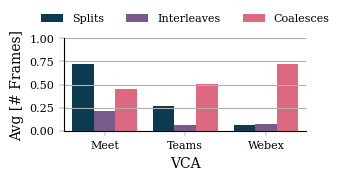

In [27]:
inac = pd.concat([dfm, dft, dfw], axis=0)[['VCA', 'frac_splits', 'frac_interleave', 'frac_coalesce']]
inac.set_index('VCA', inplace=True)
inac = inac.stack().to_frame('Avg [# Frames]').reset_index()
inac.rename(columns={'level_1':'Inaccuracy Type'},inplace=True)
sns.barplot(data=inac, x='VCA', y='Avg [# Frames]', hue='Inaccuracy Type', palette=['#003f5c','#7a5195', '#ef5675','#ffa600'], errorbar=None)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False, prop={'size': 8}, title="", labels=['Splits', 'Interleaves', 'Coalesces'])
plt.ylim([0, 1])
plt.xlabel('VCA', fontsize=10)
plt.ylabel('Avg [# Frames]', fontsize=10)
plt.gca().yaxis.grid(True)
plt.savefig('paper_plots/meet_inaccuracies.pdf', bbox_inches='tight')

In [35]:
inac.groupby(['VCA', 'Inaccuracy Type']).mean()

Avg [# Frames]
VCA   Inaccuracy Type                
Meet  frac_coalesce              0.46
      frac_interleave            0.21
      frac_splits                0.72
Teams frac_coalesce              0.50
      frac_interleave            0.07
      frac_splits                0.27
Webex frac_coalesce              0.72
      frac_interleave            0.07
      frac_splits                0.06

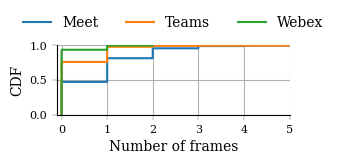

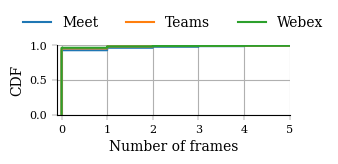

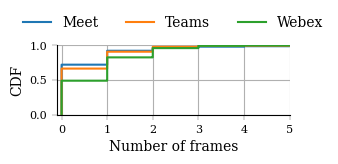

In [144]:
matplotlib.rcParams.update({'font.size': 8, 'figure.figsize' : [1.0*3, 1.5*0.6],
                           'legend.fontsize': 10, 'legend.fancybox': True,
                           'font.family': 'serif', 'font.sans-serif': 'Times',
                            'xtick.major.width': 0.2, 'xtick.minor.width': 2*0.2,
                            'ytick.major.width': 0.2, 'ytick.minor.width': 2*0.2,
                            'text.usetex': False, 'axes.labelsize': 10,
                            'axes.spines.right': False, 'axes.spines.top': False
                           })
fig, ax = plt.subplots(1, 1)
sns.ecdfplot(data=dfm, x = 'frac_splits', label='Meet', ax=ax)
sns.ecdfplot(data=dft, x = 'frac_splits', label='Teams', ax=ax)
sns.ecdfplot(data=dfw, x = 'frac_splits', label='Webex', ax=ax)
plt.xlabel('Number of frames')
plt.ylabel('CDF')
ax.legend()
ax.grid()
ax.set_xlim([-0.1, 5])
ax.set_xticks(list(range(6)))
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False)
plt.savefig('paper_plots/frame_splits_imc_lab.pdf', bbox_inches='tight')


fig, ax = plt.subplots(1, 1)
sns.ecdfplot(data=dfm, x = 'frac_interleave', label='Meet', ax=ax)
sns.ecdfplot(data=dft, x = 'frac_interleave', label='Teams', ax=ax)
sns.ecdfplot(data=dfw, x = 'frac_interleave', label='Webex', ax=ax)
plt.xlabel('Number of frames')
plt.ylabel('CDF')
ax.legend()
ax.grid()
ax.set_xlim([-0.1, 5])
ax.set_xticks(list(range(6)))
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False)
plt.savefig('paper_plots/frame_interleaves_imc_lab.pdf', bbox_inches='tight')

fig, ax = plt.subplots(1, 1)
sns.ecdfplot(data=dfm, x = 'frac_coalesce', label='Meet', ax=ax)
sns.ecdfplot(data=dft, x = 'frac_coalesce', label='Teams', ax=ax)
sns.ecdfplot(data=dfw, x = 'frac_coalesce', label='Webex', ax=ax)
plt.xlabel('Number of frames')
plt.ylabel('CDF')
ax.legend()
ax.grid()
ax.set_xlim([-0.1, 5])
ax.set_xticks(list(range(6)))
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False)
plt.savefig('paper_plots/frame_coalesces_imc_lab.pdf', bbox_inches='tight')

# Effect of WebRTC Sampling Interval

<Figure size 312.5x212.5 with 0 Axes>

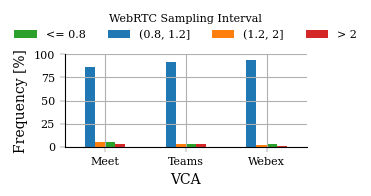

In [133]:
plt.figure(figsize=(3.125, 2.125))
df = pd.read_csv('imc_lab_results.csv', index_col=None)
dft = df[(df['metric'] == 'framesReceivedPerSecond') & (df['method'] == 'IP/UDP ML')]
dfg = dft.groupby('csv_file').agg({'lastPacketReceivedTimestamp': list, 'ts': list, 'Prediction': list, 'Ground Truth': list, 'VCA': lambda x: list(x)[0]}).reset_index()
data = {'interval_length': [], 'ts': [], 'Prediction': [], 'Ground Truth': [], 'csv_file': [], 'VCA': []}
for idx, row in dfg.iterrows():
    data['interval_length'] += list(np.array(np.diff(row['lastPacketReceivedTimestamp'])/1000))
    data['ts'] += row['ts'][1:]
    data['Prediction'] += row['Prediction'][1:]
    data['Ground Truth'] += row['Ground Truth'][1:]
    data['csv_file'] += [row['csv_file']]*(len(row['Prediction'])-1)
    data['VCA'] += [row['VCA']]*(len(row['Prediction'])-1)
dfi = pd.DataFrame(data)

dfi['Deviation'] = dfi['Prediction']-dfi['Ground Truth']

def get_interval_bin(x):
    if x <= 0.8:
        return "<= 0.8"
    elif x > 0.8 and x <= 1.2:
        return "(0.8, 1.2]"
    elif x > 1.2 and x <= 2.0:
        return "(1.2, 2]"
    else:
        return "> 2"
dfi['interval_length'] = dfi['interval_length'].apply(get_interval_bin)
dfi['VCA'] = dfi['VCA'].replace({'meet': 'Meet', 'teams': 'Teams', 'webex': 'Webex'})
counts = dfi.groupby(['VCA', 'interval_length']).size()
percentages = counts.groupby(level=0).apply(lambda x: x / float(x.sum()) * 100)

percentages = percentages.reset_index(name='Percentage')
pivot_table = percentages.pivot(index='VCA', columns='interval_length', values='Percentage')

# pivot_table = pivot_table.reindex(['<= 0.8', '(0.8, 1.2]', '(1.2, 2]', '> 2'])

pivot_table.plot.bar(rot=0)

plt.grid()
handles, labels = plt.gca().get_legend_handles_labels()
order = [2, 0, 1, 3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=4, frameon=False, prop={"size": 8}, title='WebRTC Sampling Interval')
plt.ylim([0, 100])
plt.xlabel('VCA', fontsize=10)
plt.ylabel('Frequency [%]', fontsize=10)
plt.savefig('paper_plots/sampling_interval_hist_imc_lab.pdf', bbox_inches='tight')

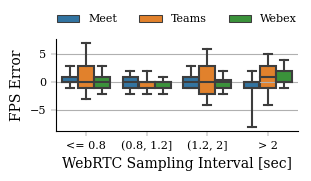

In [122]:
dfi['VCA'] = dfi['VCA'].replace({'meet': 'Meet', 'teams': 'Teams', 'webex': 'Webex'})
sns.boxplot(data = dfi, x = 'interval_length', y = 'Deviation', hue='VCA', showfliers=False, hue_order=['Meet', 'Teams', 'Webex'], whis=[10, 90], order=['<= 0.8', '(0.8, 1.2]', '(1.2, 2]', '> 2'])
# plt.ylim([-1000, 2700])
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False, prop={'size': 8})
plt.ylabel('FPS Error', fontsize=10)
plt.xlabel('WebRTC Sampling Interval [sec]', fontsize=10)
plt.gca().yaxis.grid(True)
# plt.yticks([0, 500, 1000, 1500])
plt.savefig('paper_plots/fps_sampling_interval_imc_lab.pdf', bbox_inches='tight')

In [759]:
dfi[dfi['VCA'] == 'Meet']['Deviation'].mean()

33.038016380633714

In [762]:
x = df[(df['metric'] == 'frame_jitter')& (df['method'] == 'IP/UDP Heuristic')]

<Axes: xlabel='VCA', ylabel='abs_deviation'>

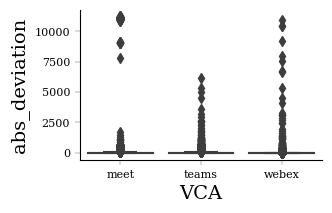

In [769]:
sns.boxplot(data=x, y = 'abs_deviation', x='VCA')
# plt.xlim([0, 100])

# Effect of Window Size

In [1140]:
ip = [[1.55,1.3,1.33, 1],[1.14,0.89,1.1, 2],[1.01,0.77,1.02, 3],[0.96,0.73,0.98, 4],[0.96,0.66,0.97, 5],[0.86,0.66,0.91, 6],[0.86,0.63,0.84, 7],[0.8,0.62,0.87, 8],[0.84,0.64,0.79, 9],[0.84,0.65,0.82, 10]]
rtp = [[1.56,1.19,1.24, 1],[1.1,0.89,1.02, 2],[0.87,0.68,0.87, 3],[0.85,0.63,0.81, 4],[0.75,0.57,0.77, 5],[0.64,0.55,0.77, 6],[0.66,0.54,0.72, 7],[0.6,0.52,0.67, 8],[0.6,0.46,0.62, 9],[0.58,0.52,0.65, 10]]

In [1141]:
ip_ = []
for arr in ip:
    arr[0], arr[1] = arr[1], arr[0]
    ip_.append(arr)
ip = pd.DataFrame(ip_, columns=['Meet', 'Teams', 'Webex', 'Prediction Window Size'])
rtp = pd.DataFrame(rtp, columns=['Meet', 'Teams', 'Webex', 'Prediction Window Size'])

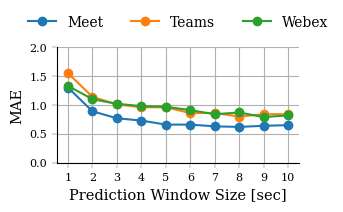

In [1186]:
ip.plot(x = 'Prediction Window Size', marker='o')
c = {'Meet': colors[-1], 'Teams': colors[7], 'Webex': colors[9]}
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False, labels=['Meet', 'Teams', 'Webex'])
plt.grid()
plt.ylabel('MAE')
plt.xlabel('Prediction Window Size [sec]')
plt.xticks(list(range(1, 11)))
plt.ylim([0, 2])
plt.savefig('paper_plots/window_size_ip_ml.pdf', bbox_inches='tight')

# Media Classification Results

In [19]:
def get_intra(l1):
    return max(l1)-min(l1)

def get_inter(l1, l2):
    return max(abs(min(l1 )-max(l2)), abs(max(l1)-min(l2)))

def filter_ptype(x):
    if type(x) != str and math.isnan(x):
        return x
    x = str(x)
    if ',' in x:
        return str(int(float(x.split(',')[0])))
    return str(int(float(x)))

vid = {'Meet': ['96', '98'], 'Webex': ['102'], 'Teams': ['102']}
rtx = {'Meet': ['99'], 'Webex': [], 'Teams': ['103']}
data = []
data2 = []
for vca in ['Meet', 'Teams', 'Webex']:
    t = df[df['VCA'] == vca]
    csvs = list(t['csv_file'].unique())
    net_columns = ['frame.time_relative','frame.time_epoch','ip.src','ip.dst','ip.proto','ip.len','udp.srcport','udp.dstport', 'udp.length','rtp.ssrc','rtp.timestamp','rtp.seq','rtp.p_type', 'rtp.marker']
    time_sum = 0
    for c in csvs:
        t = pd.read_csv(c, header=None, sep='\t', names=net_columns, lineterminator='\n', encoding='ascii').sort_values(by='frame.time_relative')
        t['rtp.p_type'] = t['rtp.p_type'].apply(filter_ptype)
        t = t[~t['ip.proto'].isna()]
        t['ip.proto'] = t['ip.proto'].astype(str)
        t = t[t['ip.proto'].str.contains(',') == False]
        t['ip.proto'] = t['ip.proto'].apply(lambda x: int(float(x)))
        ip_addr = '192.168.1.187'
        if ip_addr == 'dynamic':
            ip_addr = df.groupby('ip.dst').agg({'udp.length': sum}).reset_index().sort_values(by='udp.length', ascending=False).head(1)['ip.dst'].iloc[0]
        t = t[t["ip.dst"] == ip_addr]
        t = t[(t['ip.proto'] == 17) & (t['ip.dst'] == ip_addr)]
        src = t.groupby('ip.src').agg({'udp.length': sum, 'rtp.p_type': 'count'}).reset_index().sort_values(by='udp.length', ascending=False).head(1)['ip.src'].iloc[0]
        t = t[t['ip.src'] == src]
        t['is_rtp_video'] = False
        t['is_udp_video'] = False
        t.loc[(~t['rtp.ssrc'].isna()) & (t['rtp.p_type'].isin(vid[vca] + rtx[vca])) & (t['udp.length'] > 306), 'is_rtp_video'] = True
        dfg = t.groupby('rtp.timestamp').agg({'udp.length': list}).reset_index()
        t.loc[t['udp.length'] > 306, 'is_udp_video'] = True
        t = t.sort_values(by=['frame.time_relative'])
        t['VCA'] = vca
        t['csv'] = c
        data2.append(t)
        time_sum += t['frame.time_relative'].max() - t['frame.time_relative'].min()
        dfg['intra'] = 0
        dfg['inter'] = np.nan
        dfg['VCA'] = vca

        for i in range(1, dfg.shape[0]):
            dfg.at[i, 'intra'] = get_intra(dfg.iloc[i]['udp.length'])
            dfg.at[i, 'inter'] = get_inter(dfg.iloc[i]['udp.length'], dfg.iloc[i-1]['udp.length'])
        dfg = dfg.dropna()
        data.append(dfg)
dg = pd.concat(data, axis=0)
d = pd.concat(data2, axis=0)
d.to_csv('media_classification.csv', index=False)
dg.to_csv('grouped_rtp.csv', index=False)

In [ ]:
d = pd.read_csv('media_classification.csv', index_col=None)

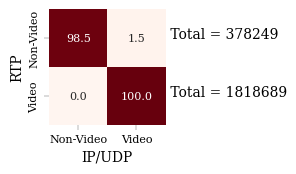

In [20]:
from sklearn.metrics import confusion_matrix
m = d[d['VCA'] == 'Teams']
plt.figure(figsize=(1.5, 1.5))
cm = confusion_matrix(y_true=m['is_rtp_video'], y_pred=m['is_udp_video'])
cm_frac = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
total = cm.sum(axis=1, keepdims=True).flatten()
p = len(total)
formatted_text = np.asarray(["{0:.2f}%".format(a) for a in cm_frac.flatten()]).reshape(cm.shape[0], cm.shape[1])
g = sns.heatmap(cm_frac, cmap='Reds', cbar=False, annot=True, fmt='.1f', xticklabels=['Non-Video', 'Video'], yticklabels=['Non-Video', 'Video'])
i = 0
for y in total:
    plt.annotate(f" Total = {y}", xy=(p, i+0.5), fontsize=10)
    i += 1
plt.ylabel('RTP', fontsize=10)
plt.xlabel('IP/UDP', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.savefig('paper_plots/Teams_media_classification.pdf', bbox_inches='tight')

In [ ]:
m[(m['is_udp_video'] == True) & (m['is_rtp_video'] == False) & (m['csv'] == '/home/taveesh/Documents/Projects/vca-qoe-inference/data/IMC_Lab_data/2023-05-16_teams_4253_551_2_0_0_47_86/teams/captures/teams-chrome-4253_551_2_0_0_47_86-1684263114.csv')]

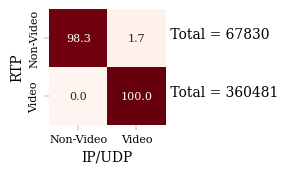

In [21]:
from sklearn.metrics import confusion_matrix
m = d[d['VCA'] == 'Meet']
plt.figure(figsize=(1.5, 1.5))
cm = confusion_matrix(y_true=m['is_rtp_video'], y_pred=m['is_udp_video'])
cm_frac = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
total = cm.sum(axis=1, keepdims=True).flatten()
p = len(total)
formatted_text = np.asarray(["{0:.2f}%".format(a) for a in cm_frac.flatten()]).reshape(cm.shape[0], cm.shape[1])
g = sns.heatmap(cm_frac, cmap='Reds', cbar=False, annot=True, fmt='.1f', xticklabels=['Non-Video', 'Video'], yticklabels=['Non-Video', 'Video'])
i = 0
for y in total:
    plt.annotate(f" Total = {y}", xy=(p, i+0.5), fontsize=10)
    i += 1
plt.ylabel('RTP', fontsize=10)
plt.xlabel('IP/UDP', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.savefig('paper_plots/Meet_media_classification.pdf', bbox_inches='tight')

In [22]:
m[(m['is_udp_video'] == True) & (m['is_rtp_video'] == False) & (m['csv'] == '/home/taveesh/Documents/Projects/vca-qoe-inference/data/IMC_Lab_data/2023-05-16_meet_10037_2835_58_5_0_41_79/meet/captures/meet-chrome-10037_2835_58_5_0_41_79-1684289798.csv')]

,frame.time_relative,frame.time_epoch,ip.src,ip.dst,ip.proto,ip.len,udp.srcport,udp.dstport,udp.length,rtp.ssrc,rtp.timestamp,rtp.seq,rtp.p_type,rtp.marker,is_rtp_video,is_udp_video,VCA,csv
1065,8.31,1684289807.50,142.250.82.185,192.168.1.187,17,1231,3478.00,60854.00,1211.00,NaN,nan,nan,NaN,nan,False,True,Meet,/home/taveesh/Documents/Projects/vca-qoe-infer...
1077,8.36,1684289807.54,142.250.82.185,192.168.1.187,17,598,3478.00,60854.00,578.00,NaN,nan,nan,NaN,nan,False,True,Meet,/home/taveesh/Documents/Projects/vca-qoe-infer...
1399,24.08,1684289823.27,142.250.82.185,192.168.1.187,17,1253,3478.00,60854.00,1233.00,NaN,nan,nan,NaN,nan,False,True,Meet,/home/taveesh/Documents/Projects/vca-qoe-infer...
1460,24.15,1684289823.34,142.250.82.185,192.168.1.187,17,337,3478.00,60854.00,317.00,NaN,nan,nan,NaN,nan,False,True,Meet,/home/taveesh/Documents/Projects/vca-qoe-infer...


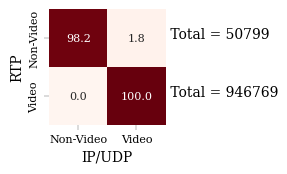

In [23]:
from sklearn.metrics import confusion_matrix
m = d[d['VCA'] == 'Webex']
plt.figure(figsize=(1.5, 1.5))
cm = confusion_matrix(y_true=m['is_rtp_video'], y_pred=m['is_udp_video'])
cm_frac = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
total = cm.sum(axis=1, keepdims=True).flatten()
p = len(total)
formatted_text = np.asarray(["{0:.2f}%".format(a) for a in cm_frac.flatten()]).reshape(cm.shape[0], cm.shape[1])
g = sns.heatmap(cm_frac, cmap='Reds', cbar=False, annot=True, fmt='.1f', xticklabels=['Non-Video', 'Video'], yticklabels=['Non-Video', 'Video'])
i = 0
for y in total:
    plt.annotate(f" Total = {y}", xy=(p, i+0.5), fontsize=10)
    i += 1
plt.ylabel('RTP', fontsize=10)
plt.xlabel('IP/UDP', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.savefig('paper_plots/Webex_media_classification.pdf', bbox_inches='tight')

# Teams Intra Size diff

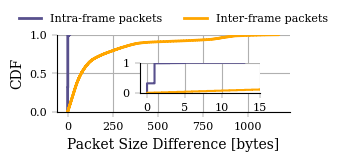

In [145]:
def filter_list(l):
    l = ast.literal_eval(l)
    return [float(x) for x in l if float(x)  > 400]
import ast
    
    
dg = pd.read_csv('grouped_rtp.csv', index_col=None)
dg = dg[dg['VCA'] == 'Teams']
dg['new_udp'] = dg['udp.length'].apply(filter_list)
dg['udp_num'] = dg['new_udp'].apply(lambda x: len(x))
dg = dg[dg['udp_num'] > 0]

dg['intra_new'] = dg['new_udp'].apply(get_intra)

# matplotlib.rcParams.update({'font.size': 8, 'figure.figsize' : [1.0*3.125, 1.5*1.0 ],                      'legend.fontsize': 10, 'legend.fancybox': True,
#                            'font.family': 'serif', 'font.sans-serif': 'Times',
#                             'xtick.major.width': 0.2, 'xtick.minor.width': 2*0.2,
#                             'ytick.major.width': 0.2, 'ytick.minor.width': 2*0.2,
#                             'text.usetex': False, 'axes.labelsize': 7,
#                             'axes.spines.right': False, 'axes.spines.top': False
#                            })
fig, ax = plt.subplots(figsize=(3, 1))
sns.ecdfplot(data=dg, x='intra_new', ax=ax, color='#58508d', linewidth=2)
sns.ecdfplot(data=dg, x='inter', ax=ax, color='#ffa600', linewidth=2)
ax.set_ylabel('CDF', fontsize=10)
ax.set_xlabel('Packet Size Difference [bytes]', fontsize=10)
ax.grid()
ax2 = plt.axes([0.4, 0.3, .4, .3])
sns.ecdfplot(data=dg, x='intra_new', ax=ax2, label='Intra-frame packets', color='#58508d')
sns.ecdfplot(data=dg, x='inter', ax=ax2, label='Inter-frame packets', color='#ffa600')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=2, frameon=False, labels=['Intra-frame packets', 'Inter-frame packets'], prop={'size': 8})
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_xticks([0,  5, 10, 15])
ax2.set_xlim([-1, 15])
ax2.grid()
fig.savefig('paper_plots/Teams_size_difference.pdf', bbox_inches='tight')

(0.95, 1.0)

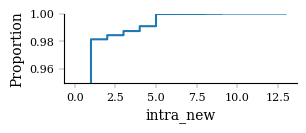

In [134]:
sns.ecdfplot(data=dg, x = 'intra_new')
plt.ylim([0.95, 1])

In [39]:
dg.shape

(360385, 5)

In [146]:
100*dg[dg['inter'] >= 2].shape[0] / dg.shape[0]

99.44040843600742

# Teams Size distributions by PType

102   89.18
103    8.24
111    2.59
Name: rtp.p_type, dtype: float64


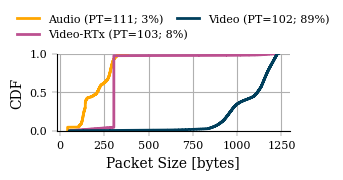

In [27]:
# print(t['frame.time_relative'].max() - t['frame.time_relative'].min())
# print(t['rtp.p_type'].unique())
plt.figure(figsize=(3, 1))
# d = d[d['is_rtp_video'] == True]
d = d[~d['rtp.ssrc'].isna()]
d['rtp.p_type'] = d['rtp.p_type'].apply(filter_ptype)
d = d[d['rtp.p_type'].isin(['111', '102', '103'])]
sns.ecdfplot(data=d, x = 'udp.length', hue = 'rtp.p_type', palette={'102': '#003f5c', '103': '#bc5090', '111': '#ffa600'}, linewidth=2)
print(d['rtp.p_type'].value_counts(normalize=True).mul(100))
labels = ['Audio (PT=111; 3%)', 'Video-RTx (PT=103; 8%)', 'Video (PT=102; 89%)']
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False, labels=labels, prop={'size':8}, columnspacing=-1)
plt.xlabel('Packet Size [bytes]', fontsize=10)
plt.ylabel('CDF', fontsize=10)
plt.grid()
plt.savefig('paper_plots/Teams_media.pdf', bbox_inches='tight')

In [69]:
d[d['rtp.p_type'] == '111']['udp.length'].max(), d[d['rtp.p_type'] == '111']['udp.length'].min()

(385.0, 89.0)

In [73]:
d[(d['udp.length'] != 76) & (d['rtp.p_type'] == '102')]['udp.length'].quantile(0.01)

564.0

In [75]:
d[(d['rtp.p_type'] == '103') & (d['udp.length'] == 304)].shape[0] / d[d['rtp.p_type'] == '103'].shape[0]

0.9294859776579955

In [77]:
time_sum = 0
for c in csvs:
    t = pd.read_csv(c, header=None, sep='\t', names=net_columns, lineterminator='\n', encoding='ascii').sort_values(by='frame.time_relative')
    t = t[~t['rtp.ssrc'].isna()]
    t['rtp.p_type'] = t['rtp.p_type'].astype(int)
    t['rtp.p_type'] = t['rtp.p_type'].astype(str)
    # data2.append(t)
    time_sum += t['frame.time_relative'].max() - t['frame.time_relative'].min()
time_sum

16528.08883590899

In [139]:
dfj = df[(df['metric'] == 'frame_jitter') & (df['method'] == 'IP/UDP ML') & (df['VCA'] == 'teams')]
dfj.to_csv('jitter_lab_teams.csv', index=False)
dfj['Dataset'] = 'In-Lab'

In [138]:
dfr = pd.read_csv('jitter_rw_teams.csv', index_col=None)
dfr['Dataset'] = 'Real World'

In [140]:
d = pd.concat([dfr, dfj], axis=0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


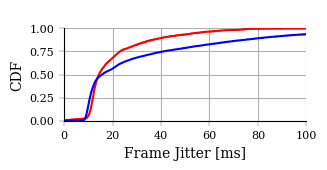

In [150]:
fig, ax = plt.subplots(1,1)
sns.ecdfplot(data=d[d['Dataset'] == 'Real World'], x = 'Prediction', color='r', ls=None, ax=ax, label='Real World Prediction')
# sns.ecdfplot(data=d[d['Dataset'] == 'Real World'], x = 'Ground Truth', color='r', ls='--', ax=ax, label='Real World Ground Truth')
sns.ecdfplot(data=d[d['Dataset'] == 'In-Lab'], x = 'Prediction', color='b', ls=None, ax=ax, label='In-Lab Prediction')
# sns.ecdfplot(data=d[d['Dataset'] == 'In-Lab'], x = 'Ground Truth', color='b', ls='--', ax=ax, label='In-Lab Ground Truth')
plt.xlim([0, 100])
plt.xlabel('Frame Jitter [ms]', fontsize=10)
plt.ylabel('CDF', fontsize=10)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False, prop={'size': 8})
plt.grid()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


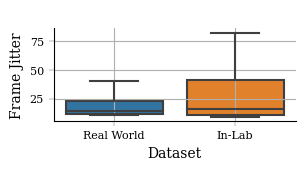

In [156]:
fig, ax = plt.subplots(1,1)
sns.boxplot(data=d, x = 'Dataset', y='Prediction', showfliers=False, whis=[10, 90], ax=ax)
# sns.ecdfplot(data=d[d['Dataset'] == 'In-Lab'], x = 'Ground Truth', color='b', ls='--', ax=ax, label='In-Lab Ground Truth')
# plt.xlim([0, 100])
plt.xlabel('Dataset', fontsize=10)
plt.ylabel('Frame Jitter', fontsize=10)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False, prop={'size': 8})
plt.grid()

In [160]:
d.groupby('Dataset')['Prediction'].describe(percentiles=[0.1, 0.9])

,count,mean,std,min,10%,50%,90%,max
Dataset,,,,,,,,
In-Lab,13786.00,36.39,59.56,0.27,9.46,15.64,82.70,2263.63
Real World,3586.00,20.73,15.30,0.00,10.69,14.36,40.84,173.34


In [162]:
d.groupby('Dataset')['Ground Truth'].describe(percentiles=[0.1, 0.9])

,count,mean,std,min,10%,50%,90%,max
Dataset,,,,,,,,
In-Lab,13786.00,32.76,128.71,0.00,7.58,12.48,57.80,6202.98
Real World,3586.00,20.04,24.44,0.00,7.25,12.67,41.94,486.50


In [174]:
x = [[0.85, 0.77, 0.82, 10], [0.79, 0.71, 0.79, 9], [0.9, 0.77, 0.87, 8], [0.86, 0.73, 0.84, 7], [0.97, 0.78, 0.91, 6], [1.01, 0.82, 0.96, 5], [1.04, 0.83, 0.98, 4], [1.07, 0.88, 0.99, 3], [1.23, 1.03, 1.09, 2], [1.6, 1.58, 1.32, 1]]
ip = pd.DataFrame(x, columns=['Teams', 'Meet', 'Webex', 'Window Size'])

ip = ip[['Meet', 'Teams', 'Webex', 'Window Size']]

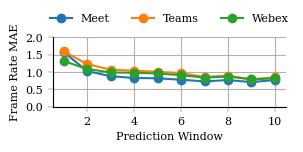

In [186]:
ip.plot(x='Window Size', marker='o')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False, prop={'size': 8})
plt.grid()
plt.ylabel('Frame Rate MAE', fontsize=8)
plt.xlabel('Prediction Window', fontsize=8)
plt.ylim([0, 2])
plt.yticks([0, 0.5, 1, 1.5, 2])
plt.savefig('paper_plots/window_size_ip_ml.pdf', bbox_inches='tight')